# Bike Sharing Demand

### 1. Business Understanding

### 2. Data Understanding

The data set is similar to the bike sharing dataset provided by the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). However, the aforementioned dataset only contains data for 2011 and 2012. It was originally created by Fanaee-T and Gama (2013) in their study ["Event labeling combining ensemble detectors and background knowledge"](https://link.springer.com/article/10.1007/s13748-013-0040-3). 

To have a larger dataset, I collected the following data from the following sources for the time period of January 1, 2011 until December 31, 2018:
* The bike demand data comes from [Capital Bike Share](http://capitalbikeshare.com/system-data)
* The weather data was taken from [NOAA's National Climatic Data Center](https://www.ncdc.noaa.gov/cdo-web/search)
* The holiday data is from the [DC Department of Human Resources](http://dchr.dc.gov/page/holiday-schedule). 

The dataset uses data from the bike sharing stations of Capital Bike Share in the metro D.C. area in the United States. The weather data and holiday data refer to the same location.


In [1]:
import pandas as pd
import numpy as np
import math
import pickle
from scipy.stats import kruskal, pearsonr, randint, uniform, chi2_contingency, boxcox
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer, StandardScaler, power_transform
from sklearn.linear_model import SGDClassifier
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_validate, TimeSeriesSplit, RandomizedSearchCV, GridSearchCV, cross_val_predict
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, kpss, acf, pacf
from collections import defaultdict, OrderedDict
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.decomposition import PCA
from statsmodels.tsa.ar_model import AR
from skits.feature_extraction import AutoregressiveTransformer
from skits.preprocessing import ReversibleImputer
from sklearn.linear_model import LinearRegression
import xgboost as xgb

import seaborn as sb
import matplotlib.pyplot as plt 

%matplotlib inline


In [2]:
# diplaying all columns without truncation in dataframes
pd.set_option('display.max_columns', 500)


#### 2.1. Loading the data and visualizing and describing it

In [3]:
# read in bike sharing dataset
bike_df = pd.read_csv('bike_sharing_dataset.csv')
bike_df.head()


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,wt_sleet,wt_hail,wt_glaze,wt_haze,wt_drift_snow,wt_high_wind,wt_mist,wt_drizzle,wt_rain,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday
0,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,330.0,629.0,959.0,NaN
1,2011-01-02,NaN,0.880000,13.806667,7.327273,1.037349,3.925,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,130.0,651.0,781.0,NaN
2,2011-01-03,NaN,-3.442857,7.464286,-3.060000,1.878824,3.625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,1181.0,1301.0,NaN
3,2011-01-04,NaN,-5.957143,4.642857,-3.100000,0.000000,1.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,1429.0,1536.0,NaN
4,2011-01-05,NaN,-4.293333,6.113333,-1.772727,0.000000,2.950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.0,1489.0,1571.0,NaN


In [4]:
# print descriptive statistics
bike_df.describe()


,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,wt_sleet,wt_hail,wt_glaze,wt_haze,wt_drift_snow,wt_high_wind,wt_mist,wt_drizzle,wt_rain,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday
count,2101.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,1503.0,208.0,694.0,129.0,50.0,153.0,705.0,7.0,258.0,371.0,128.0,406.0,5.0,84.0,36.0,10.0,4.0,1.0,2918.000000,2918.000000,2918.000000,89.0
mean,14.419007,8.506468,19.015689,11.069243,3.435734,3.162898,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1679.776217,6046.297121,7726.073338,1.0
std,9.556401,9.473941,9.835524,9.481232,8.183658,1.379582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1560.762932,2756.888032,3745.220092,0.0
min,-12.100000,-16.993750,-7.980000,-15.658333,0.000000,0.375000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.000000,19.000000,21.000000,1.0
25%,6.566667,0.516538,11.081562,3.013068,0.005510,2.200000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,512.250000,3839.250000,4628.500000,1.0
50%,15.433333,8.504911,19.992857,11.619091,0.271504,2.900000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1220.500000,5964.000000,7442.500000,1.0
75%,23.066667,17.338393,27.874583,19.767083,2.885381,3.875000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2357.250000,8187.500000,10849.500000,1.0
max,31.733333,26.206250,37.850000,28.666667,118.789796,12.750000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10173.000000,15419.000000,19113.000000,1.0


In [5]:
# check the datatypes of each variable
bike_df.dtypes


date                  object
temp_avg             float64
temp_min             float64
temp_max             float64
temp_observ          float64
precip               float64
wind                 float64
wt_fog               float64
wt_heavy_fog         float64
wt_thunder           float64
wt_sleet             float64
wt_hail              float64
wt_glaze             float64
wt_haze              float64
wt_drift_snow        float64
wt_high_wind         float64
wt_mist              float64
wt_drizzle           float64
wt_rain              float64
wt_freeze_rain       float64
wt_snow              float64
wt_ground_fog        float64
wt_ice_fog           float64
wt_freeze_drizzle    float64
wt_unknown           float64
casual               float64
registered           float64
total_cust           float64
holiday              float64
dtype: object

These are the meanings of each variable in the dataset:
- date: date
- temp_avg: average temperature in Celcius
- temp_min: minimum temperature in Celcius
- temp_max: maximum temperature in Celcius
- temp_observ: temperature at time of observation
- precip: precipitation in mm 
- wind: average windspeed
- wt: weather types
    - fog: fog, ice fog, or freezing fog (may include heavy fog)
    - heavy_fog: heavy fog or heaving freezing fog (not always distinguished from fog)
    - thunder: thunder
    - sleet: ice pellets, sleet, snow pellets, or small hail
    - hail: hail (may include small hail)
    - glaze: glaze or rime
    - haze: smoke or haze
    - drift_snow: blowing or drifting snow 
    - high_wind: high or damaging winds
    - mist: mist
    - drizzle: drizzle
    - rain: rain (may include freezing rain, drizzle, and freezing drizzle)
    - freeze_rain: freezing rain
    - snow: snow, snow pellets, snow grains, or ice crystals
    - ground_fog: ground fog
    - ice_fog: ice for or freezing fog
    - freeze_drizzle: freezing drizzle
    - unknown: unknown source of precipitation
- casual: count of casual users
- registered: count of registered users
- total_cust: count of total rental bikes including both casual and registered
- holiday: holiday in Washington D.C.


##### Checking for and dealing with missing values

In [6]:
# Check for missing values
bike_df.isnull().sum()


date                    0
temp_avg              821
temp_min                0
temp_max                0
temp_observ             0
precip                  0
wind                    0
wt_fog               1419
wt_heavy_fog         2714
wt_thunder           2228
wt_sleet             2793
wt_hail              2872
wt_glaze             2769
wt_haze              2217
wt_drift_snow        2915
wt_high_wind         2664
wt_mist              2551
wt_drizzle           2794
wt_rain              2516
wt_freeze_rain       2917
wt_snow              2838
wt_ground_fog        2886
wt_ice_fog           2912
wt_freeze_drizzle    2918
wt_unknown           2921
casual                  4
registered              4
total_cust              4
holiday              2833
dtype: int64

The feature **temp_avg** is missing 821 values. I will investigate whether keeping this feature is even necessary given the other three temperature features. There are also 4 values missing for **casual, registered and total_cust** features and the target, respectively. I will check why these are missing and exclude those observations because if the target variable is missing, I cannot estimate it. 

The **holiday** feature has NAs but these should actually 0s, which I will convert. The **wt_** features also have NAs where 0s should be which I will insert.


In [7]:
# fill NAs with 0 where applicable
wt_feats = [x for x in bike_df.columns if 'wt' in x]
bike_df['holiday'] = bike_df['holiday'].fillna(0)
bike_df[wt_feats] = bike_df[wt_feats].fillna(0)


In [8]:
# check casual, registered and total_cust missing rows
missing_target = bike_df[bike_df['total_cust'].isna()]
missing_target


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,wt_sleet,wt_hail,wt_glaze,wt_haze,wt_drift_snow,wt_high_wind,wt_mist,wt_drizzle,wt_rain,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday
1848,2016-01-23,-4.366667,-6.128571,-2.392857,-4.688889,42.045946,8.08,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
1849,2016-01-24,-2.666667,-7.985714,-1.028571,-6.366667,19.339130,3.75,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
1850,2016-01-25,-5.133333,-11.128571,2.028571,-9.877778,0.000000,1.15,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
1851,2016-01-26,2.333333,-7.871429,7.471429,3.588889,0.000000,2.85,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0


There seem to be four days where no data was captured for the rented bikes. Because this is a time series, I am not sure whether I can drop these rows or whether I should interpolate the target values for these four days. More research is necessary to determine this.

In [9]:
# filling the missing values in the customer variables with forward fill method
bike_df[['total_cust', 'casual', 'registered']] = bike_df[['total_cust', 'casual', 'registered']].fillna(
                                                            method='ffill')
bike_df.isnull().sum()


date                   0
temp_avg             821
temp_min               0
temp_max               0
temp_observ            0
precip                 0
wind                   0
wt_fog                 0
wt_heavy_fog           0
wt_thunder             0
wt_sleet               0
wt_hail                0
wt_glaze               0
wt_haze                0
wt_drift_snow          0
wt_high_wind           0
wt_mist                0
wt_drizzle             0
wt_rain                0
wt_freeze_rain         0
wt_snow                0
wt_ground_fog          0
wt_ice_fog             0
wt_freeze_drizzle      0
wt_unknown             0
casual                 0
registered             0
total_cust             0
holiday                0
dtype: int64

In [10]:
# check what the correlation between the different temperature features and total_cust is
# maybe I could just use one of the other temperature features instead of temp_avg

# correlation between temp_avg and total_cust
# I'm excluding the first 820 rows because they contain missing temp_avg values
print('temp_avg:', pearsonr(bike_df['temp_avg'][821:], bike_df['total_cust'][821:]))

# correlation between temp_min and total_cust
print('temp_min:', pearsonr(bike_df['temp_min'], bike_df['total_cust']))
print('temp_min, without first 820 rows:', pearsonr(bike_df['temp_min'][821:], bike_df['total_cust'][821:]))

# correlation between temp_max and total_cust
print('temp_max:', pearsonr(bike_df['temp_max'], bike_df['total_cust']))
print('temp_max, without first 820 rows:', pearsonr(bike_df['temp_max'][821:], bike_df['total_cust'][821:]))

# correlation between temp_observ and total_cust
print('temp_observ:', pearsonr(bike_df['temp_observ'], bike_df['total_cust']))
print('temp_observ, without first 820 rows:', pearsonr(bike_df['temp_observ'][821:], bike_df['total_cust'][821:]))


temp_avg: (0.7289653483071338, 0.0)
temp_min: (0.5484063784007367, 3.9226572899081034e-229)
temp_min, without first 820 rows: (0.6720561174778342, 3.520489340545429e-276)
temp_max: (0.5962507437902363, 6.98668965923709e-281)
temp_max, without first 820 rows: (0.7406902128448435, 0.0)
temp_observ: (0.5500110613450738, 9.817169026469553e-231)
temp_observ, without first 820 rows: (0.6804926361142356, 9.04108786780588e-286)


The above shows that disregarding the first 820 rows leads to the highest correlation between temp_max and total_cust. Comparing temp_avg with the entire dataset and the respective correlations with total_cust, temp_avg has the highest correlation.

The Granger causality is a more appropriate measure for timeseries data and understanding how one variable can determine another variable. Thus, below I am using the Granger causality test to see how the temperature features cause total_cust.

In [11]:
# calculating the Granger causality between the temperature feats and the target
print('Average temperature and target:')
grangercausalitytests(bike_df[['total_cust', 'temp_avg']][821:], maxlag=1);
print('\nMaximum temperature and target:')
grangercausalitytests(bike_df[['total_cust', 'temp_max']], maxlag=1);
print('\nMinimum temperature and target:')
grangercausalitytests(bike_df[['total_cust', 'temp_min']], maxlag=1);
print('\nObserved temperature and target:')
grangercausalitytests(bike_df[['total_cust', 'temp_observ']], maxlag=1);


Average temperature and target:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=176.4496, p=0.0000  , df_denom=2097, df_num=1
ssr based chi2 test:   chi2=176.7020, p=0.0000  , df=1
likelihood ratio test: chi2=169.6602, p=0.0000  , df=1
parameter F test:         F=176.4496, p=0.0000  , df_denom=2097, df_num=1

Maximum temperature and target:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=40.0233 , p=0.0000  , df_denom=2918, df_num=1
ssr based chi2 test:   chi2=40.0645 , p=0.0000  , df=1
likelihood ratio test: chi2=39.7922 , p=0.0000  , df=1
parameter F test:         F=40.0233 , p=0.0000  , df_denom=2918, df_num=1

Minimum temperature and target:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=88.8911 , p=0.0000  , df_denom=2918, df_num=1
ssr based chi2 test:   chi2=88.9825 , p=0.0000  , df=1
likelihood ratio test: chi2=87.6540 , p=0.0000  , df=1
parameter F test:         F=88.8911 , p=0.0000  , df_denom=2918,

#### 2.2. Preprocessing

Below I will engineer some new features from the categorical and numeric features

In [12]:
# function to create seasons for dataframe
def seasons(df):
    '''
    Function to create new features for seasons based on months
    Args: df = dataframe
    Returns: df = dataframe
    '''
    
    # create a season features
    df['season_spring'] = df['date'].apply(lambda x: 1 if '01' in x[5:7] else 1 if '02' in x[5:7] else 1 
                                                     if '03' in x[5:7] else 0)
    df['season_summer'] = df['date'].apply(lambda x: 1 if '04' in x[5:7] else 1 if '05' in x[5:7] else 1 
                                                     if '06' in x[5:7] else 0)
    df['season_fall'] = df['date'].apply(lambda x: 1 if '07' in x[5:7] else 1 if '08' in x[5:7] else 1 
                                                     if '09' in x[5:7] else 0)
    
    return df


In [13]:
### create new features for seasons
bike_df = seasons(bike_df)


In [14]:
### create new feature weekday
bike_df['date_datetime'] = bike_df['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

bike_df['weekday'] = bike_df['date_datetime'].apply(lambda x: x.weekday())


In [15]:
### one hot encode the feature weekday
weekday_dummies = pd.get_dummies(bike_df['weekday'], prefix='weekday', drop_first=True)
bike_df = bike_df.join(weekday_dummies, how='left')
bike_df.head()


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,wt_sleet,wt_hail,wt_glaze,wt_haze,wt_drift_snow,wt_high_wind,wt_mist,wt_drizzle,wt_rain,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday,season_spring,season_summer,season_fall,date_datetime,weekday,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,330.0,629.0,959.0,0.0,1,0,0,2011-01-01,5,0,0,0,0,1,0
1,2011-01-02,NaN,0.880000,13.806667,7.327273,1.037349,3.925,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,130.0,651.0,781.0,0.0,1,0,0,2011-01-02,6,0,0,0,0,0,1
2,2011-01-03,NaN,-3.442857,7.464286,-3.060000,1.878824,3.625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,1181.0,1301.0,0.0,1,0,0,2011-01-03,0,0,0,0,0,0,0
3,2011-01-04,NaN,-5.957143,4.642857,-3.100000,0.000000,1.800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,1429.0,1536.0,0.0,1,0,0,2011-01-04,1,1,0,0,0,0,0
4,2011-01-05,NaN,-4.293333,6.113333,-1.772727,0.000000,2.950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.0,1489.0,1571.0,0.0,1,0,0,2011-01-05,2,0,1,0,0,0,0


In [16]:
### create new feature working_day
bike_df['working_day'] = bike_df['weekday'].apply(lambda x: 0 if x > 5 or x == 0 else 1)
bike_df['working_day'] = bike_df[['holiday', 'working_day']].apply(
    lambda x: 0 if x['holiday'] == 1 else x['working_day'], axis=1)


##### Dropping unnecessary columns

I will drop the date feature and keep the date_datetime feature to have the feature with the correct date formatting. The registered and casual features will also be dropped because they are sub-features of the total_cust target label. I will also drop the temp_avg variable.

In [17]:
# Dropping date, registered and casual features because this is in string format 
bike_df.drop(columns=['date', 'temp_avg', 'registered', 'casual'], inplace=True)


#### 2.3. Exploratory Data Analysis

#### Categorical variables

##### Season

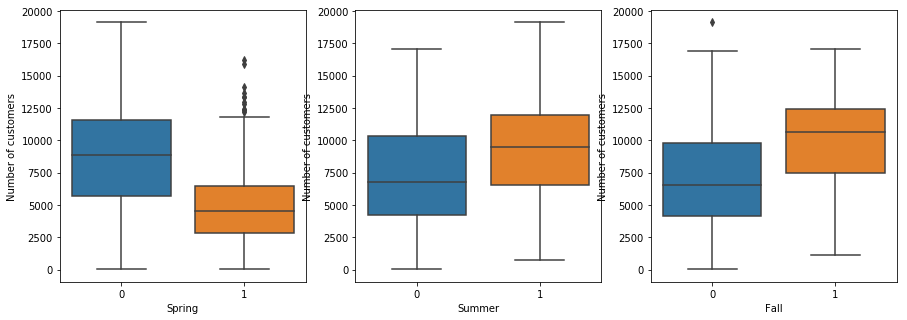

In [18]:
# variable to be used below to iterate through the columns and plot them
season_names = ['season_spring', 'season_summer', 'season_fall']

# plot boxplots for season versus number of users
plt.figure(figsize = [15, 5])

# boxplot for feature workingday
plt.subplot(1, 3, 1)
sb.boxplot(data = bike_df, x = 'season_spring', y = 'total_cust')
plt.xlabel('Spring')
plt.ylabel('Number of customers')

# boxplot for feature weekday
plt.subplot(1, 3, 2)
sb.boxplot(data = bike_df, x = 'season_summer', y = 'total_cust')
plt.xlabel('Summer')
plt.ylabel('Number of customers')

# boxplot for feature holiday
plt.subplot(1, 3, 3)
sb.boxplot(data = bike_df, x = 'season_fall', y = 'total_cust')
plt.xlabel('Fall')
plt.ylabel('Number of customers');


In [19]:
# Correlation between season features and the maximum temperature
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(bike_df['temp_max'], bike_df['season_summer'])


KruskalResult(statistic=4190.2337936410495, pvalue=0.0)

The season feature clearly determines the customer demand for bikes, so this feature will be used for the final model.

##### holiday

The features holiday, weekday and workingday have some overlaps in their prediction of customer demand, thus, I will first analyze each individual feature and then investigate their correlation.

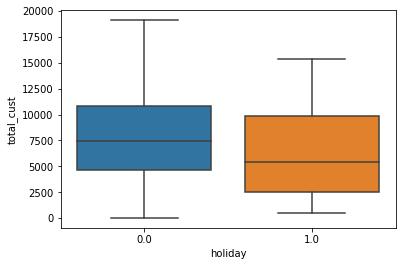

In [20]:
# plotting the customer statistics in form of a boxplot for the holiday feature
sb.boxplot(data = bike_df, x = 'holiday', y = 'total_cust');


For the holiday feature, we can clearly see that there is on average a higher demand for bikes on days that are not holidays. This feature will be used in the final model to predict the overall demand.

In [21]:
# Correlation between holiday feature and the number of customers per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(bike_df['holiday'], bike_df['total_cust'])


KruskalResult(statistic=4945.69275502358, pvalue=0.0)

##### weekday

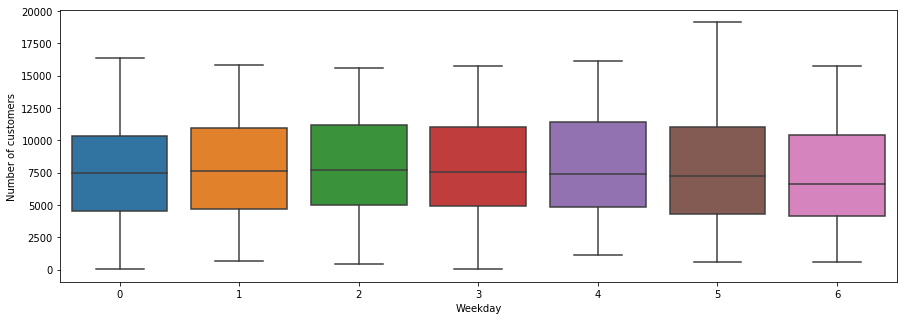

In [22]:
# plotting the customer statistics in form of a boxplot for the weekday feature
plt.figure(figsize = [15, 5])
sb.boxplot(data = bike_df, x = 'weekday', y = 'total_cust')
plt.xlabel('Weekday')
plt.ylabel('Number of customers');


In [23]:
# Correlation between weekday feature and the number of customers per day
# using Pearson's correlation coefficient because I'm assuming that weekday can be 
# considered a continuous variable
pearsonr(bike_df['weekday'], bike_df['total_cust'])


(-0.02476089857240885, 0.18086518739732843)

Based on the above distributions of number of customers per weekday, it appears that there are slight difference in demand depending on what weekday it is. Thus, the weekday will be considered to forecast the bike demand. But I still need to onehot encode the weekday because it is a categorical feature.

##### workingday

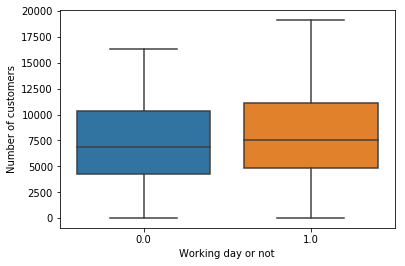

In [24]:
# plotting workday feature in boxplot against the count of customers
sb.boxplot(data = bike_df, x = 'working_day', y = 'total_cust')
plt.xlabel('Working day or not')
plt.ylabel('Number of customers');


In [25]:
# Correlation between working_day feature and the number of customers per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(bike_df['working_day'], bike_df['total_cust'])


KruskalResult(statistic=4596.399701396863, pvalue=0.0)

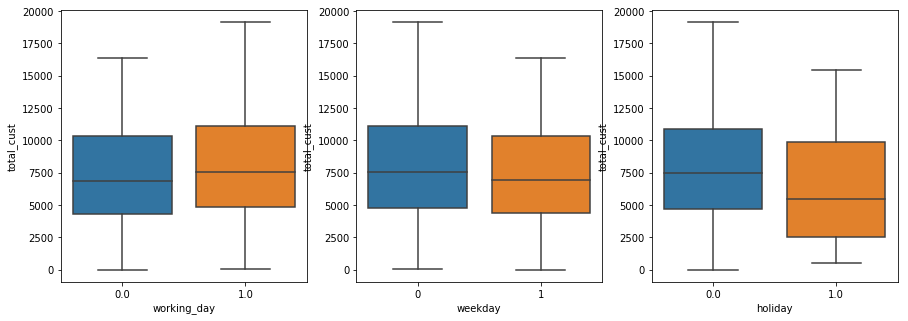

In [26]:
# create a new dataframe that encodes the weekday feature with 0 for monday through friday
# and 1 for saturday and sunday
weekend_distinct_df = bike_df.copy()
weekend_distinct_df['weekday'] = weekend_distinct_df['weekday'].apply(lambda x: 1 if (x == 6 or x == 0) else 0)

# plot boxplots for comparison between the weekday and workingday feature
plt.figure(figsize = [15, 5])

# boxplot for feature workingday
plt.subplot(1, 3, 1)
sb.boxplot(data = bike_df, x = 'working_day', y = 'total_cust');

# boxplot for feature weekday
plt.subplot(1, 3, 2)
sb.boxplot(data = weekend_distinct_df, x = 'weekday', y = 'total_cust');

# boxplot for feature holiday
plt.subplot(1, 3, 3)
sb.boxplot(data = bike_df, x = 'holiday', y = 'total_cust');


In [27]:
# plot the means of each instance of workingday
bike_df.groupby('working_day')['total_cust'].mean()


working_day
0.0    7262.673563
1.0    7913.302144
Name: total_cust, dtype: float64

In [28]:
# plot the means of each instance of weekday
weekend_distinct_df.groupby('weekday')['total_cust'].mean()


weekday
0    7878.716203
1    7322.511962
Name: total_cust, dtype: float64

In [29]:
# plot the means of each instance of holiday
bike_df.groupby('holiday')['total_cust'].mean()


holiday
0.0    7771.698200
1.0    6060.685393
Name: total_cust, dtype: float64

The features holiday, weekday and workingday are correlated with each other as well as with the target variable total_cust. However, they contain slightly different information that may be useful for predicting the target variable. Thus, I will keep all three variables for my model.

##### weather type features wt

The wt_ features contain the following features and meanings:
- wt_fog: fog, ice fog, or freezing fog (may include heavy fog)
- wt_heavy_fog: heavy fog or heaving freezing fog (not always distinguished from fog)
- wt_thunder: thunder
- wt_sleet: ice pellets, sleet, snow pellets, or small hail
- wt_hail: hail (may include small hail)
- wt_glaze: glaze or rime
- wt_haze: smoke or haze
- wt_drift_snow: blowing or drifting snow 
- wt_high_wind: high or damaging winds
- wt_mist: mist
- wt_drizzle: drizzle
- wt_rain: rain (may include freezing rain, drizzle, and freezing drizzle)
- wt_freeze_rain: freezing rain
- wt_snow: snow, snow pellets, snow grains, or ice crystals
- wt_ground_fog: ground fog
- wt_ice_fog: ice for or freezing fog
- wt_freeze_drizzle: freezing drizzle
- wt_unknown: unknown source of precipitation

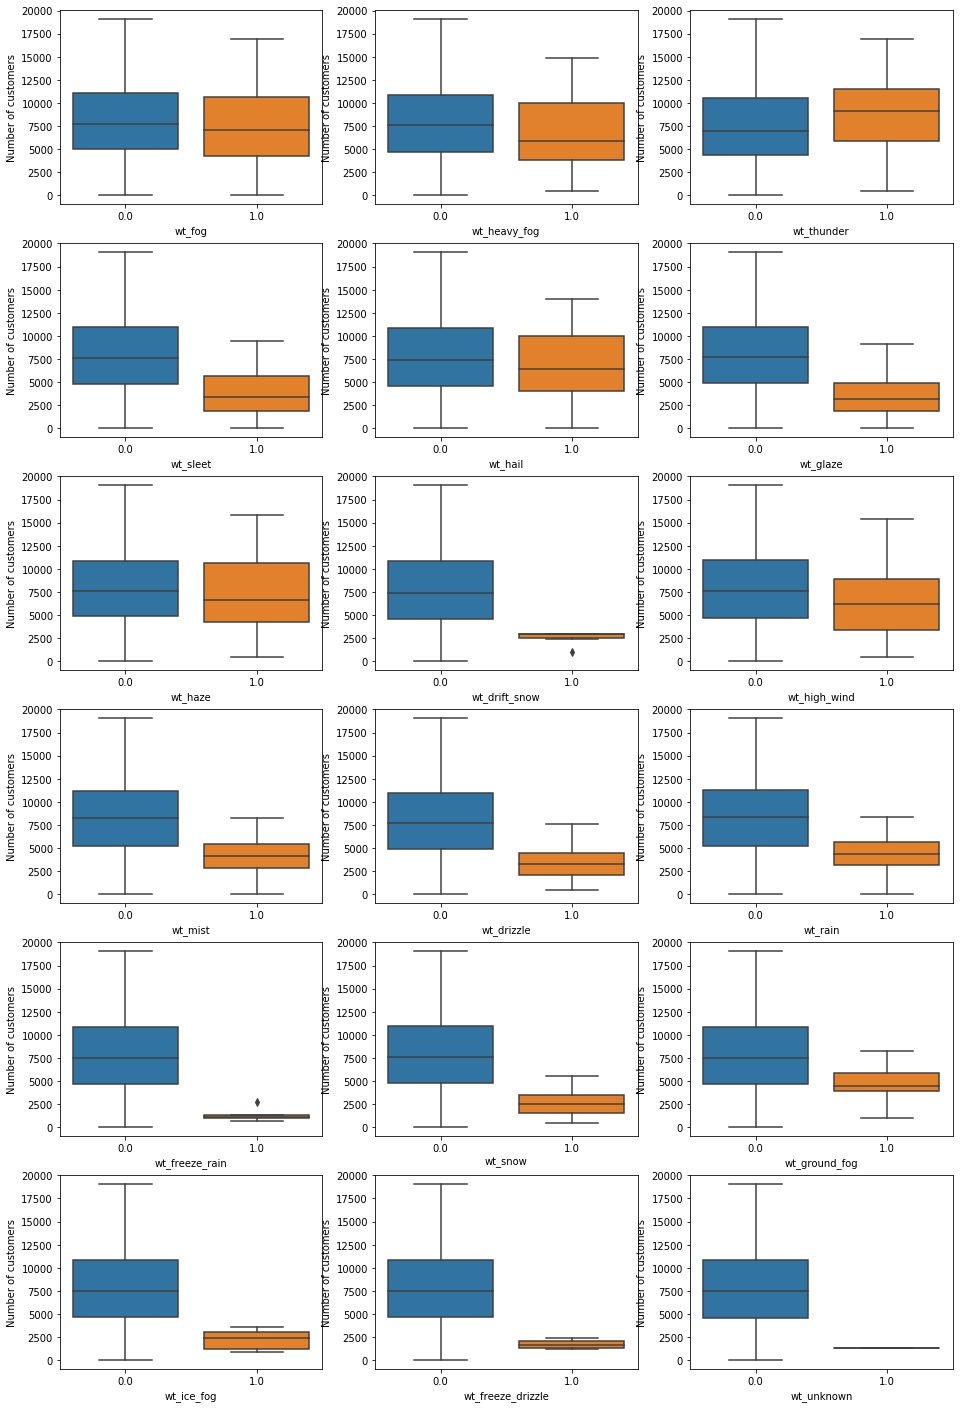

In [30]:
# plotting the revenue of the most common production companies vs. the rest
fig, ax = plt.subplots(6, 3, figsize = [16, 25])

# create list with all feature names 
wt_feat_list = [x for x in bike_df.columns if 'wt_' in x]

# company counter
counter = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 5 and i == 3:
            break
        else:
            ax[j][i] = sb.boxplot(data = bike_df, x = wt_feat_list[counter], y = 'total_cust', ax=ax[j][i])
            ax[j][i].set_ylabel('Number of customers')
            ax[j][i].set_xlabel(wt_feat_list[counter])
            counter += 1
            

Based on the distributions of the target value depending on the weather feature as well as based on the assessment of similar descriptive weather names/patterns, I will merge some of the weather features together.

In [31]:
# fog, heavy fog, hail, haze, high wind
bike_df['foggy'] = bike_df['wt_fog'] + bike_df['wt_heavy_fog'] + bike_df['wt_hail'] + bike_df['wt_haze'] + bike_df['wt_high_wind']
bike_df['foggy'] = bike_df['foggy'].apply(lambda x: 0 if x == 0 else 1)

# thunder
bike_df['thunder'] = bike_df['wt_thunder']

# ice_fog, unknown, freeze_drizzle, freeze_rain, drift_snow
bike_df['ice'] = bike_df['wt_ice_fog'] + bike_df['wt_unknown'] + bike_df['wt_freeze_drizzle'] + bike_df['wt_freeze_rain'] + bike_df['wt_drift_snow']
bike_df['ice'] = bike_df['ice'].apply(lambda x: 0 if x == 0 else 1)

# sleet, glaze, snow
bike_df['sleet'] = bike_df['wt_sleet'] + bike_df['wt_glaze'] + bike_df['wt_snow']
bike_df['sleet'] = bike_df['sleet'].apply(lambda x: 0 if x == 0 else 1)

# mist, drizzle, rain, ground fog
bike_df['rain'] = bike_df['wt_mist'] + bike_df['wt_drizzle'] + bike_df['wt_rain'] + bike_df['wt_ground_fog']
bike_df['rain'] = bike_df['rain'].apply(lambda x: 0 if x == 0 else 1)



In [32]:
# drop the old wt features
bike_df.drop(columns=wt_feats, inplace=True)


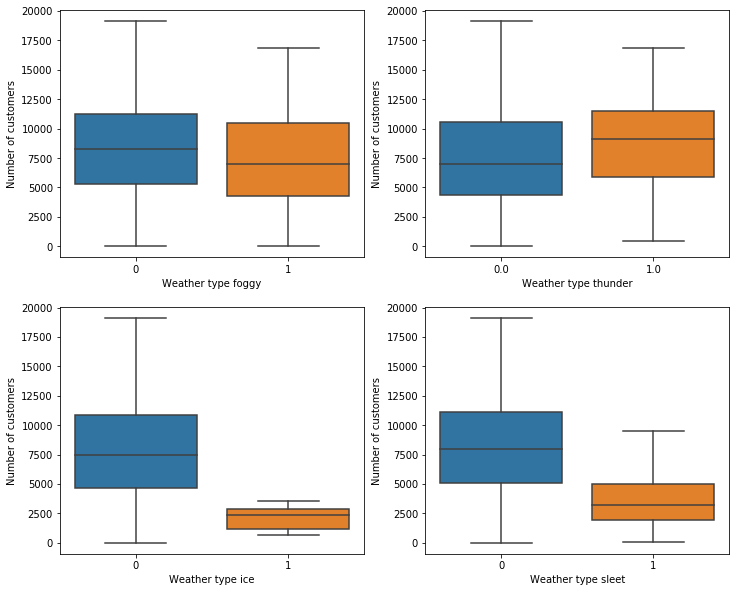

In [33]:
# plot boxplots for comparison between the new weather type features and target
plt.figure(figsize = [12, 10])

# boxplot for feature foggy
plt.subplot(2, 2, 1)
sb.boxplot(data = bike_df, x = 'foggy', y = 'total_cust')
plt.xlabel('Weather type foggy')
plt.ylabel('Number of customers')

# boxplot for feature thunder
plt.subplot(2, 2, 2)
sb.boxplot(data = bike_df, x = 'thunder', y = 'total_cust')
plt.xlabel('Weather type thunder')
plt.ylabel('Number of customers')

# boxplot for feature ice
plt.subplot(2, 2, 3)
sb.boxplot(data = bike_df, x = 'ice', y = 'total_cust')
plt.xlabel('Weather type ice')
plt.ylabel('Number of customers')

# boxplot for feature sleet
plt.subplot(2, 2, 4)
sb.boxplot(data = bike_df, x = 'sleet', y = 'total_cust')
plt.xlabel('Weather type sleet')
plt.ylabel('Number of customers');



<Figure size 1080x432 with 0 Axes>

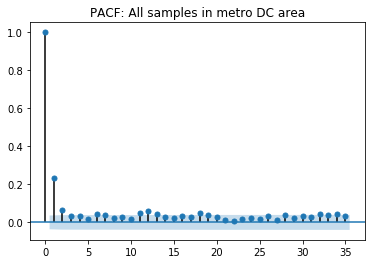

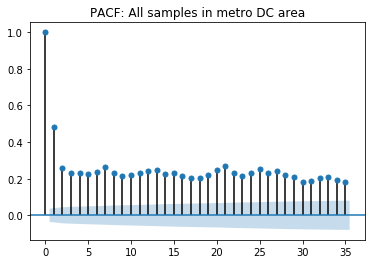

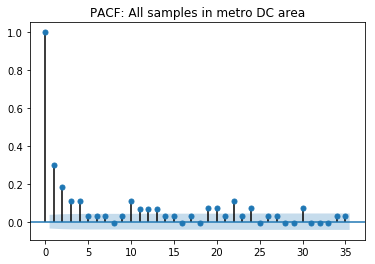

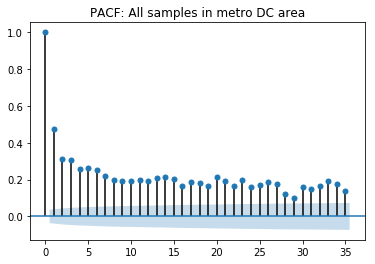

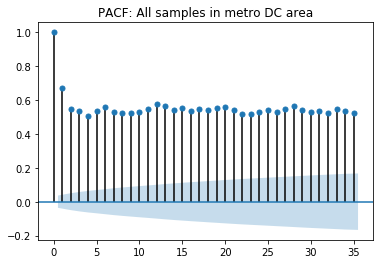

In [34]:
# plotting the acf of wt_ features
plt.figure(figsize=[15,6])

plot_acf(bike_df['foggy'], title='PACF: All samples in metro DC area',)
plt.show()

plot_acf(bike_df['thunder'], title='PACF: All samples in metro DC area',)
plt.show()

plot_acf(bike_df['ice'], title='PACF: All samples in metro DC area',)
plt.show()

plot_acf(bike_df['sleet'], title='PACF: All samples in metro DC area',)
plt.show()

plot_acf(bike_df['rain'], title='PACF: All samples in metro DC area',)
plt.show()


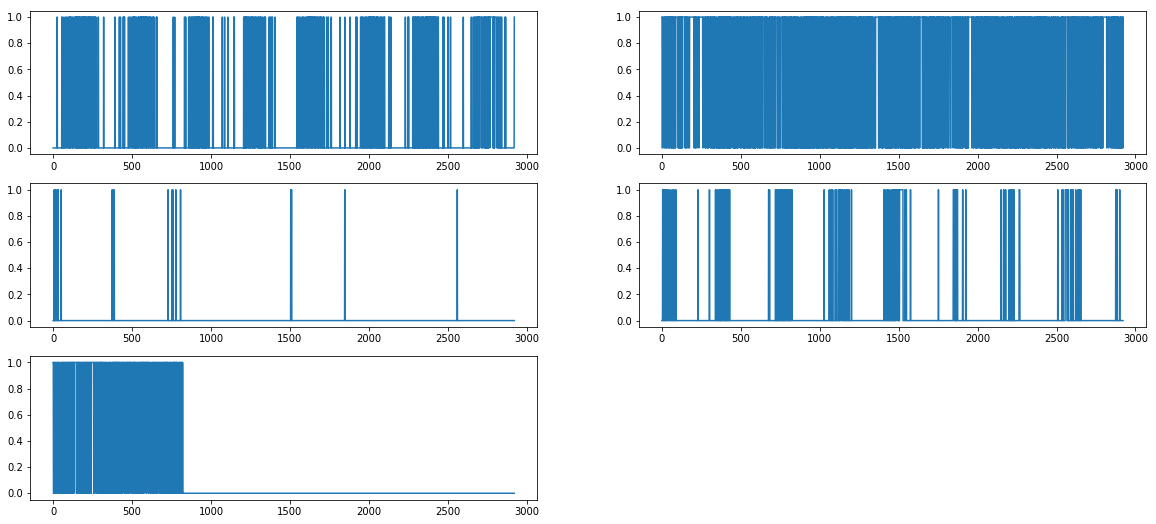

In [35]:
# plotting all newly created features
plt.figure(figsize=[20,9])

plt.subplot(3,2,1)
plt.plot(bike_df['thunder'])

plt.subplot(3, 2, 2)
plt.plot(bike_df['foggy'])

plt.subplot(3, 2, 3)
plt.plot(bike_df['ice'])

plt.subplot(3, 2, 4)
plt.plot(bike_df['sleet'])

plt.subplot(3, 2, 5)
plt.plot(bike_df['rain'])


The newly created rain feature seems to have been discontinued after two years into the time series. I will therefore drop this feature.

In [36]:
bike_df.drop(columns=['rain'], inplace=True)

In [37]:
# get list for all correlations between temp_max and total_cust with different rolling means

def best_window_sum(x, y, max_window):
    corr_temp_cust = []
    for i in range(1, max_window):
        roll_val = list(x.rolling(i).sum()[i-1:-1])
        total_cust_ti = list(y[i:])
        corr, p_val = pearsonr(total_cust_ti, roll_val)
        corr_temp_cust.append(corr)
    # get the optimal window size for rolling mean between temp_max and total_cust
    max_val = np.argmax(corr_temp_cust)
    min_val = np.argmin(corr_temp_cust)
    opt_corr_min = corr_temp_cust[min_val]
    opt_corr_max = corr_temp_cust[max_val]
    
    results = {max_val+1: opt_corr_max, min_val+1: opt_corr_min}
    
    return results
    

In [38]:
# get the optimal window for rolling std for temperature
print(best_window_sum(bike_df['foggy'], bike_df['total_cust'], 30))

# get the correlation for window size determined by temp_max
foggy_mean = bike_df['foggy'].rolling(16).sum()[15:-1]
pearsonr(foggy_mean, bike_df['total_cust'][16:])


{3: -0.034541175652506494, 29: -0.08701177677103929}


(-0.05980681751209326, 0.0012574138876455573)

In [39]:
# get the optimal window for rolling std for temperature
print(best_window_sum(bike_df['thunder'], bike_df['total_cust'], 30))

# get the correlation for window size determined by temp_max
thunder_mean = bike_df['thunder'].rolling(16).sum()[15:-1]
pearsonr(thunder_mean, bike_df['total_cust'][16:])


{29: 0.43489519712545144, 1: 0.21740383154927376}


(0.41375534427511906, 1.4025656037447433e-120)

In [40]:
# get the optimal window for rolling std for temperature
print(best_window_sum(bike_df['ice'], bike_df['total_cust'], 30))

# get the correlation for window size determined by temp_max
ice_mean = bike_df['ice'].rolling(16).sum()[15:-1]
pearsonr(ice_mean, bike_df['total_cust'][16:])


{1: -0.1376282340431496, 29: -0.31631508748700815}


(-0.2903783668977481, 1.4388123697130566e-57)

In [41]:
# get the optimal window for rolling std for temperature
print(best_window_sum(bike_df['sleet'], bike_df['total_cust'], 30))

# get the correlation for window size determined by temp_max
sleet_mean = bike_df['sleet'].rolling(16).sum()[15:-1]
pearsonr(sleet_mean, bike_df['total_cust'][16:])


{1: -0.3064358074731027, 21: -0.43628302776959116}


(-0.42902977712736284, 1.8194350210845113e-130)

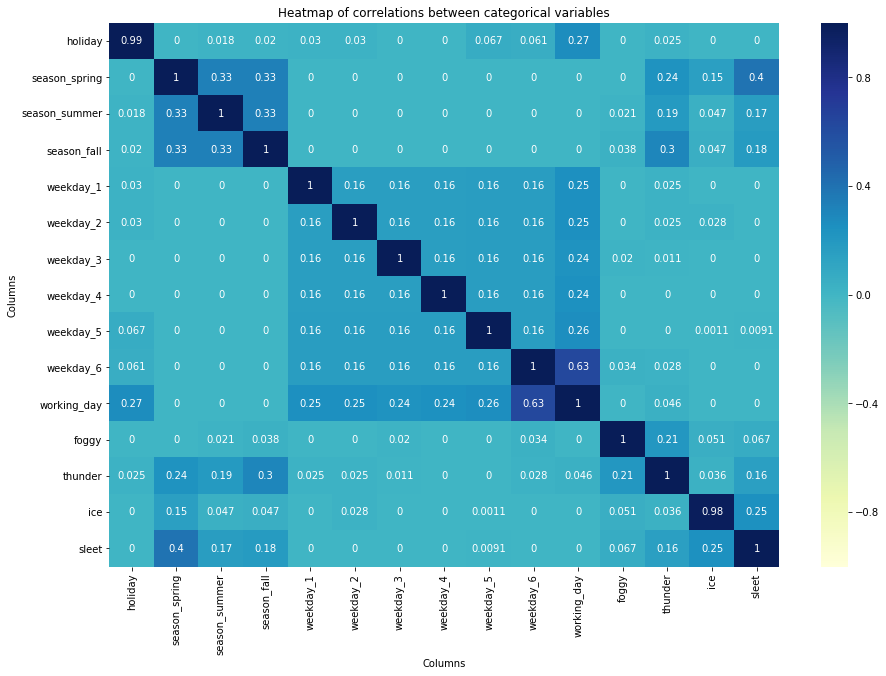

In [42]:
# drop any non-categorical variables
bike_df_corr_cat = bike_df.drop(columns=['date_datetime', 'weekday', 'temp_min', 'temp_max',
                                         'temp_observ', 'precip', 'wind', 'total_cust'], axis=1)


# this code snippet was taken from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


# create correlation matrix with cramer's V coefficients
corr_matrix = pd.DataFrame(data = None, index=np.arange(len(bike_df_corr_cat.columns)), 
                            columns=bike_df_corr_cat.columns)

for col in bike_df_corr_cat.columns:
    count = 0
    for val in bike_df_corr_cat.columns:
        corr_cat = cramers_v(bike_df_corr_cat[col], bike_df_corr_cat[val])
        corr_matrix[col][count] = corr_cat
        count += 1
    corr_matrix = corr_matrix.astype('float')


# add an index to the dataframe
corr_matrix['columns'] = bike_df_corr_cat.columns
corr_matrix.set_index('columns', inplace=True)

# plot a heatmap for correlations between categorical variables
plt.figure(figsize=[15,10])
sb.heatmap(corr_matrix, annot=True,
          vmin=-1, vmax=1, center=0,
          fmt='.2g', cmap='YlGnBu')
plt.title('Heatmap of correlations between categorical variables')
plt.xlabel('Columns')
plt.ylabel('Columns');


The values of less than 1 for correlations between a feature and itself can be explained by very small sample sizes for the chi-squared test that cramer's v builds on. Moreover, there are a few correlations between the weather type features which I should exploit and merge together.

#### Continuous variables


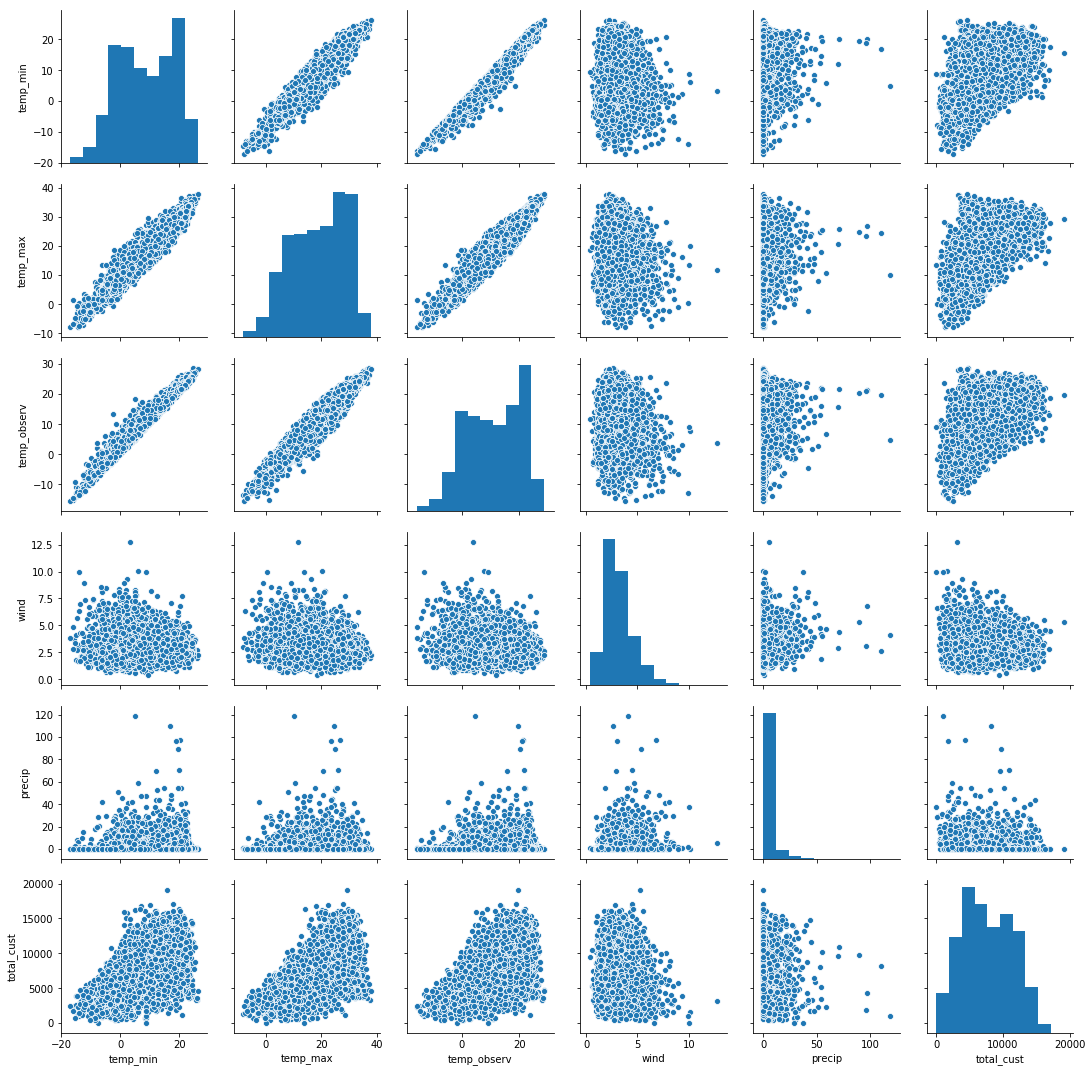

In [43]:
# plot all distributions and scatterplot between each continuous variable pair
sb.pairplot(bike_df, vars=['temp_min', 'temp_max', 'temp_observ', 'wind', 'precip', 'total_cust']);


Based on the results of the above pairplot, the following things are apparent:
* **wind looks like a Weibull distribution**
* there are almost **perfect linear relationships among the three temp features**
* **precip feature is left skewed**
* there is **no linear relationship between precip and any other feature**
* **wind** has **no linear relationship with any other feature**
* the **temp features** have a **medium strong linear relationship with the total_cust target**



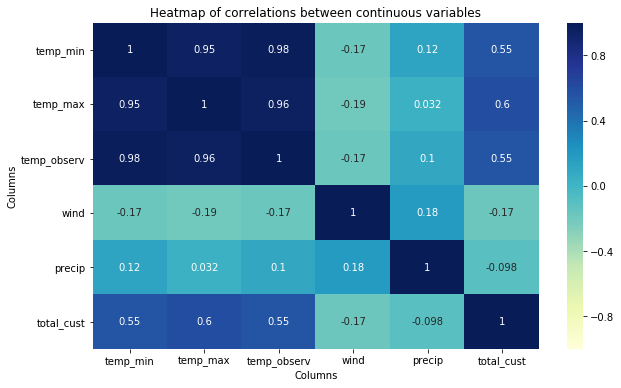

In [44]:
# create a correlation matrix
bike_df_corr = bike_df[['temp_min', 'temp_max', 'temp_observ', 'wind', 'precip', 'total_cust']].corr()

# create a heatmap to visualize the results
plt.figure(figsize=[10,6])
sb.heatmap(bike_df_corr, annot=True,
          vmin=-1, vmax=1, center=0,
          cmap='YlGnBu')
plt.title('Heatmap of correlations between continuous variables')
plt.xlabel('Columns')
plt.ylabel('Columns');


The heatmap underlines the indications of the pairplot and a number of steps need to be taken:
* the temp features are highly correlated with each other. I will keep both temp_max and temp_min because I tried it in the model and it was working better with keeping both features and Zeng et al. 2012 also use both temp_min and temp_max. 
* there are only low to very low negative correlations between wind and precip with the target label, respectively. However, I will keep both features in my model.


In [45]:
# get list for all correlations between temp_max and total_cust with different rolling means

def best_window(x, y, max_window):
    corr_temp_cust = []
    for i in range(1, max_window):
        roll_val = list(x.rolling(i).mean()[i-1:-1])
        total_cust_ti = list(y[i:])
        corr, p_val = pearsonr(total_cust_ti, roll_val)
        corr_temp_cust.append(corr)
    # get the optimal window size for rolling mean between temp_max and total_cust
    max_val = np.argmax(corr_temp_cust)
    min_val = np.argmin(corr_temp_cust)
    opt_corr_min = corr_temp_cust[min_val]
    opt_corr_max = corr_temp_cust[max_val]
    
    results = {max_val+1: opt_corr_max, min_val+1: opt_corr_min}
    
    return results
    

In [46]:
# get list for all correlations between temp_max and total_cust with different rolling standard deviations

def best_window_std(x, y, max_window):
    corr_temp_cust = []
    for i in range(2, max_window):
        roll_val = list(x.rolling(i).std()[i-1:-1])
        total_cust_ti = list(y[i:])
        corr, p_val = pearsonr(total_cust_ti, roll_val)
        corr_temp_cust.append(corr)
    # get the optimal window size for rolling mean between temp_max and total_cust
    max_val = np.argmax(corr_temp_cust)
    min_val = np.argmin(corr_temp_cust)
    opt_corr_min = corr_temp_cust[min_val]
    opt_corr_max = corr_temp_cust[max_val]
    
    results = {max_val+1: opt_corr_max, min_val+1: opt_corr_min}
    
    return results


##### total_cust

C:\Users\julia\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


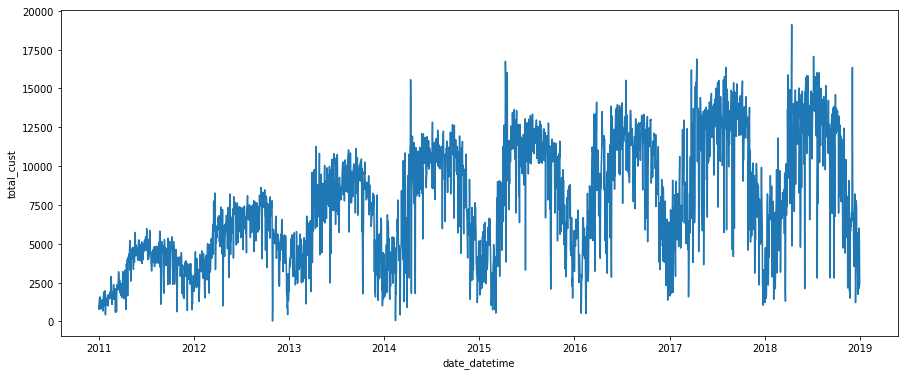

In [47]:
# plot the overall total_cust values for entire timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='total_cust', data=bike_df)


It is very obvious that this time series is non-stationary. I need to deal with this later on before using the data in my model.

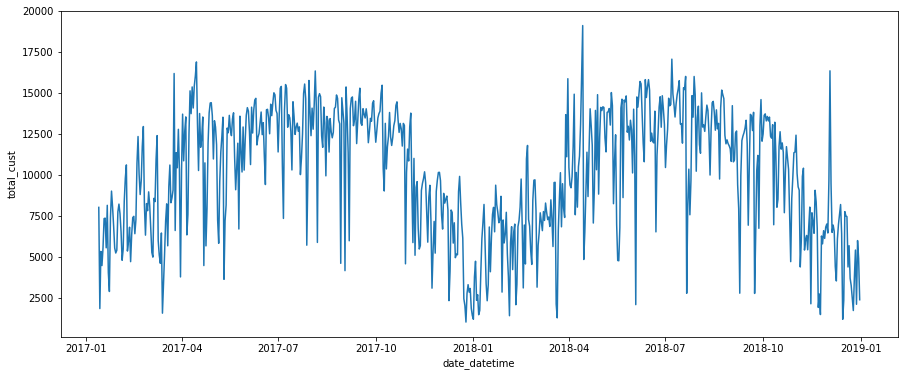

In [48]:
# plot only last two years of timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='total_cust', data=bike_df[-718:])


**PACF to determine optimal lag for total_cust target label**

Details on the process can be found [here](https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8) and [here](https://towardsdatascience.com/understanding-partial-auto-correlation-fa39271146ac). We want to avoid using variables with multicolinearity and thus, we do not want to use too many lag variables. 

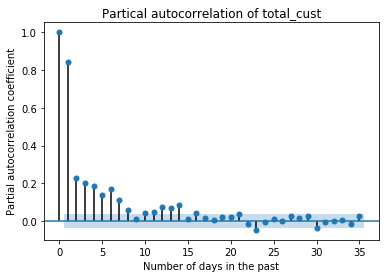

In [49]:
# plotting the partial autocorrelation for target
plot_pacf(bike_df['total_cust'], title='Partical autocorrelation of total_cust',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()


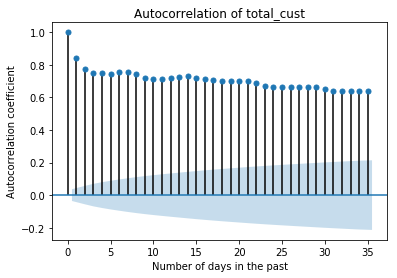

In [50]:
# plotting the autocorrelation for target
plot_acf(bike_df['total_cust'], title='Autocorrelation of total_cust',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation coefficient')
plt.show()


Based on the above plot, a lag of 1 shows significant correlation with t+0. Because of this high correlation, I will use the target variable at t-1 in my models.

In [51]:
# get the optimal window for rolling std for temperature
print(best_window_std(bike_df['total_cust'], bike_df['total_cust'], 30))

# get the correlation for window size determined by total_cust
cust_mean = bike_df['total_cust'].rolling(8).std()[7:-1]
pearsonr(cust_mean, bike_df['total_cust'][8:])

{28: 0.422973802116884, 1: 0.14849910136165329}


(0.3208335205188463, 9.428776427990169e-71)

In [52]:
# get the optimal number for rolling mean window
print(best_window(bike_df['total_cust'], bike_df['total_cust'], 30))

# get the correlation for window size determined by total_cust
cust_mean = bike_df['total_cust'].rolling(8).mean()[7:-1]
pearsonr(cust_mean, bike_df['total_cust'][8:])


{8: 0.8523138629506777, 29: 0.8292172214075906}


(0.8523138629506777, 0.0)

In [53]:
# add the value from t-1
bike_df['total_cust_t-1'] = bike_df['total_cust'].shift()


##### temp_max

In [54]:
# create series that group the mean temperature per season
temp_spring = bike_df.groupby('season_spring')['temp_max'].mean().rename({1: 'Spring'})
temp_summer = bike_df.groupby('season_summer')['temp_max'].mean().rename({1: 'Summer'})
temp_fall = bike_df.groupby('season_fall')['temp_max'].mean().rename({1: 'Fall'})

# add them to one series and drop the rows with index 0
temp_seasons = temp_spring.append(temp_summer).append(temp_fall)
temp_seasons.drop(labels=[0], inplace=True)


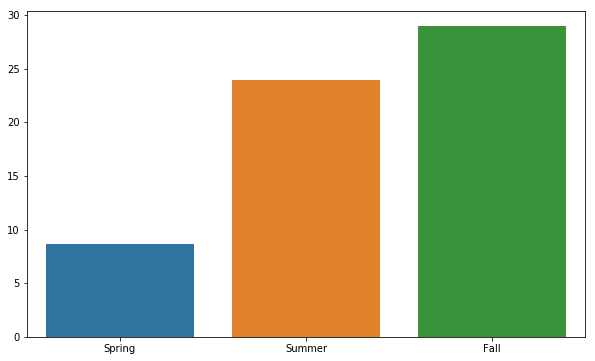

In [55]:
# plot average temp_max per season
plt.figure(figsize=[10,6])
sb.barplot(x=temp_seasons.index, y=temp_seasons.values);


In [56]:
# create series that groups average users per season
cust_spring = bike_df.groupby('season_spring')['total_cust'].mean().rename({1: 'Spring'})
cust_summer = bike_df.groupby('season_summer')['total_cust'].mean().rename({1: 'Summer'})
cust_fall = bike_df.groupby('season_fall')['total_cust'].mean().rename({1: 'Fall'})

# add them to one series and drop the rows with index 0
cust_seasons = cust_spring.append(cust_summer).append(cust_fall)
cust_seasons.drop(labels=[0], inplace=True)


<Figure size 1080x504 with 0 Axes>

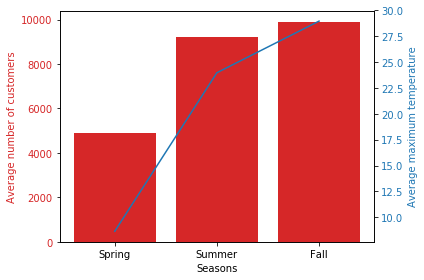

In [57]:
# assign x and y1 and y2
x = list(temp_seasons.index)
y1 = cust_seasons.values
y2 = temp_seasons.values

# below code adapted from https://matplotlib.org/gallery/api/two_scales.html
# creat plot containing both average count of customers
# and average temp per month
plt.figure(figsize=[15,7])
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color1 = 'tab:red'
ax1.set_xlabel('Seasons')
ax1.set_ylabel('Average number of customers', color=color1)
ax1.bar(x, y1, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

color2 = 'tab:blue'
ax2.set_ylabel('Average maximum temperature', color=color2)
ax2.plot(x, y2, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.show()


From the above graph we can see that the month variable is correlated with the average number of customers per that month as well as the average temperature. The temperature strongly determines the number of customers. The temperature is likely a very important feature for predicting the target variable.

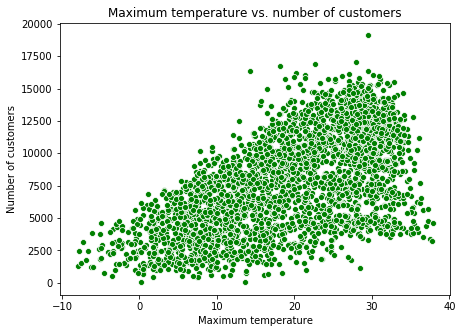

In [58]:
# plotting temp feature against the target label cnt
plt.figure(figsize=[7,5])

sb.scatterplot(data = bike_df, x = 'temp_max', y = 'total_cust', color='green')
plt.xlabel('Maximum temperature')
plt.ylabel('Number of customers')
plt.title('Maximum temperature vs. number of customers');



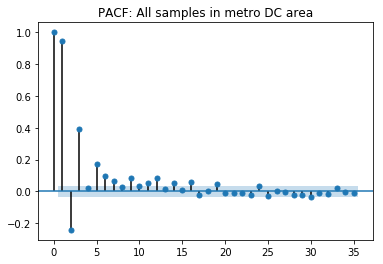

In [59]:
# plot the partial autocorrelation of temp_max
plot_pacf(bike_df['temp_max'], title='PACF: All samples in metro DC area',)
plt.show()


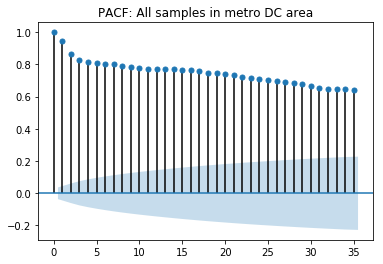

In [60]:
# autocorrelation of temp_max
plot_acf(bike_df['temp_max'], title='PACF: All samples in metro DC area',)
plt.show()


In [61]:
# get the optimal window for rolling std for temperature
print(best_window_std(bike_df['temp_max'], bike_df['total_cust'], 30))

# get the correlation for window size determined by temp_max
temp_mean = bike_df['temp_max'].rolling(8).std()[7:-1]
pearsonr(temp_mean, bike_df['total_cust'][8:])

{1: -0.14741062394923732, 21: -0.27608100636621047}


(-0.22323589445417782, 3.119764870929079e-34)

In [62]:
# get the optimal window for rolling mean for temperature
best_window(bike_df['temp_max'], bike_df['total_cust'], 30)


{16: 0.5581955383359077, 29: 0.540475143240248}

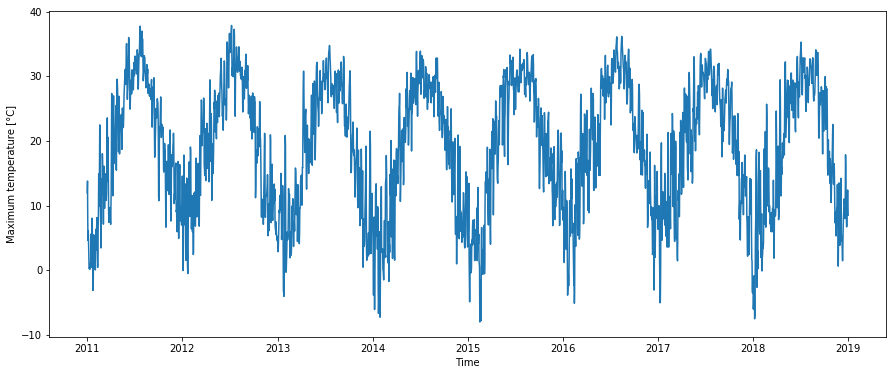

In [63]:
# plot the overall temp_max values for entire timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='temp_max', data=bike_df)
plt.ylabel('Maximum temperature [°C]')
plt.xlabel('Time');


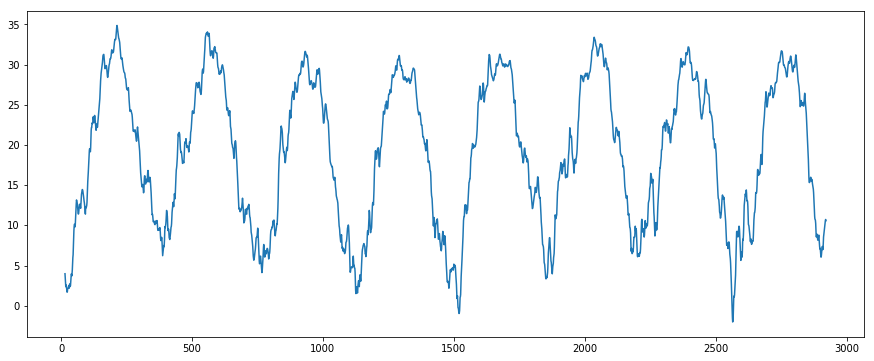

In [64]:
# create plot of rolling means
plt.figure(figsize=[15,6])

plt.plot(bike_df['temp_max'].rolling(16).mean());


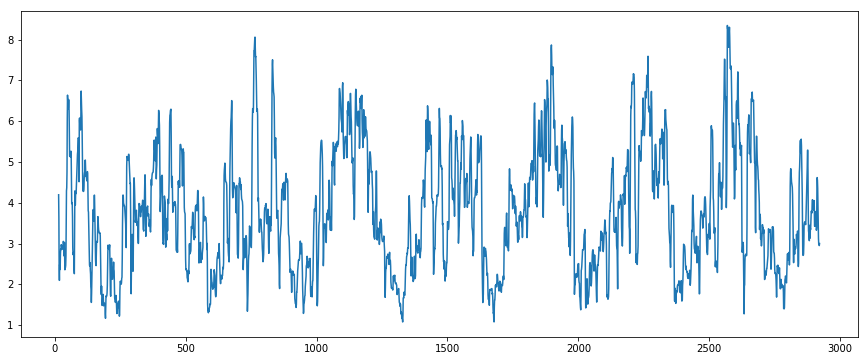

In [65]:
# create plot of rolling stds
plt.figure(figsize=[15,6])

plt.plot(bike_df['temp_max'].rolling(16).std());


##### temp_min
I will continue to use temp_min for my analysis as well, even though there is a high correlation between the temp_max and temp_min feature. Collinearity does not matter with tree-based methods, therefore, I can keep it.


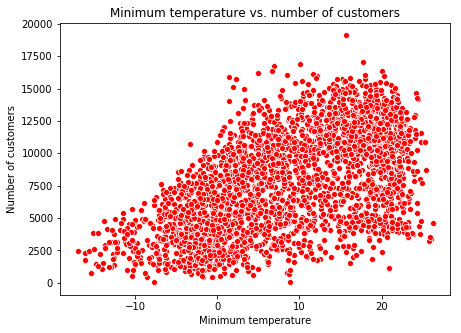

In [66]:
# plotting temp feature against the target label cnt
plt.figure(figsize=[7,5])

sb.scatterplot(data = bike_df, x = 'temp_min', y = 'total_cust', color='red')
plt.xlabel('Minimum temperature')
plt.ylabel('Number of customers')
plt.title('Minimum temperature vs. number of customers');



I will categorize the temperature similarly to what the paper by El-Assi et al. (2015) did:
* Very Cold (below 0) 
* Cold (between 0 and 10)
* Cool (between 10 and 20) 
* Warm (between 20 to 30)
* Hot (30 or more)


In [67]:
# engineer new categorical temp features
bike_df_cat = bike_df.copy()
bike_df_cat['very_cold'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 0 else 0)
bike_df_cat['cold'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 10 and x >= 0 else 0)
bike_df_cat['cool'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 20 and x >= 10 else 0)
bike_df_cat['warm'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 30 and x >= 20 else 0)
bike_df_cat['hot'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x >= 30 else 0)

bike_df_cat[['very_cold', 'cold', 'cool', 'warm', 'hot']] = bike_df_cat[['very_cold', 'cold', 'cool', 'warm', 'hot']].shift()


bike_df_cat = bike_df_cat.iloc[1:,:]

In [68]:
pearsonr(bike_df_cat['total_cust'], bike_df_cat['cold'])

(-0.40159108263149856, 1.2224202560234676e-113)

Text(0, 0.5, 'Number of customers')

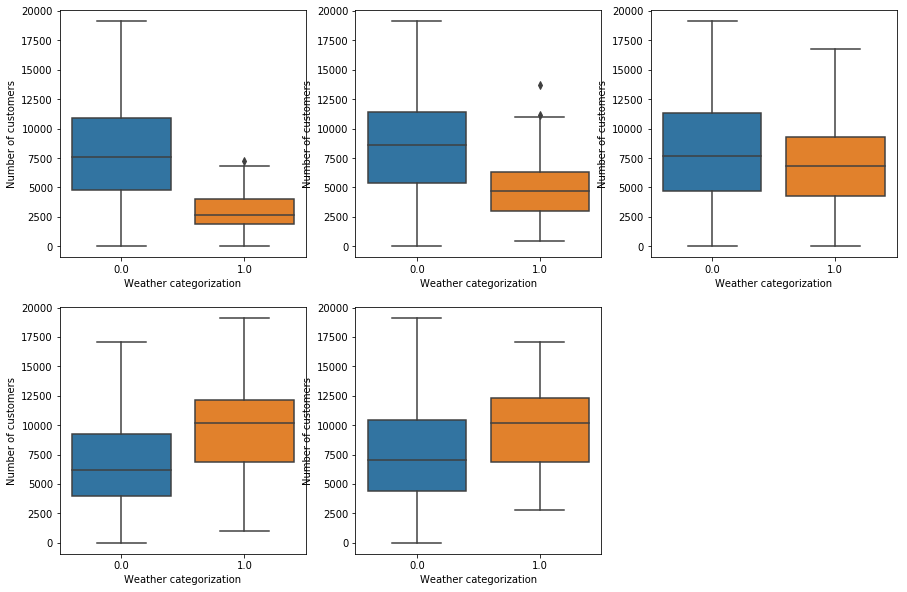

In [69]:
# plot categorized temperature
plt.figure(figsize=[15,10])
plt.subplot(2,3,1)
sb.boxplot(bike_df_cat['very_cold'], bike_df_cat['total_cust'])
plt.xlabel('Weather categorization')
plt.ylabel('Number of customers')

plt.subplot(2,3,2)
sb.boxplot(bike_df_cat['cold'], bike_df_cat['total_cust'])
plt.xlabel('Weather categorization')
plt.ylabel('Number of customers')

plt.subplot(2,3,3)
sb.boxplot(bike_df_cat['cool'], bike_df_cat['total_cust'])
plt.xlabel('Weather categorization')
plt.ylabel('Number of customers')

plt.subplot(2,3,4)
sb.boxplot(bike_df_cat['warm'], bike_df_cat['total_cust'])
plt.xlabel('Weather categorization')
plt.ylabel('Number of customers')

plt.subplot(2,3,5)
sb.boxplot(bike_df_cat['hot'], bike_df_cat['total_cust'])
plt.xlabel('Weather categorization')
plt.ylabel('Number of customers')


##### precip

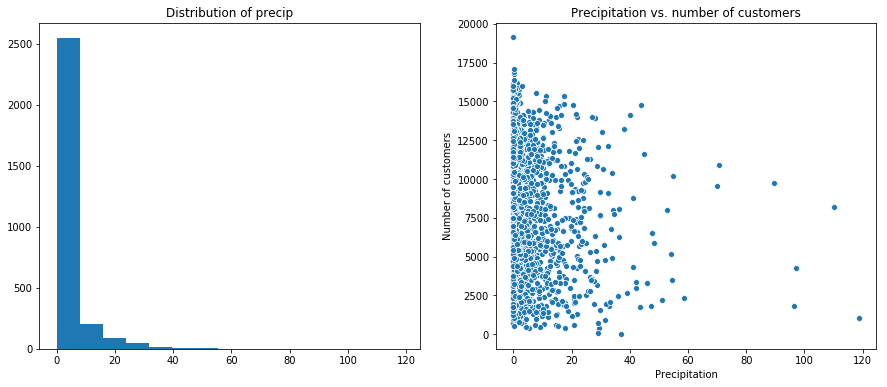

In [70]:
# plotting the distribution of precip
plt.figure(figsize=[15,6])

plt.subplot(1,2,1)
plt.hist(bike_df['precip'], bins=15)
plt.title('Distribution of precip')

plt.subplot(1,2,2)
sb.scatterplot(data = bike_df, x = 'precip', y = 'total_cust')
plt.xlabel('Precipitation')
plt.ylabel('Number of customers')
plt.title('Precipitation vs. number of customers');


Although precip is only correlated with total_cust in a weak sense, I will keep this in the model. This distribution is also left-skewed, so a logarithmic transformation will be necessary.

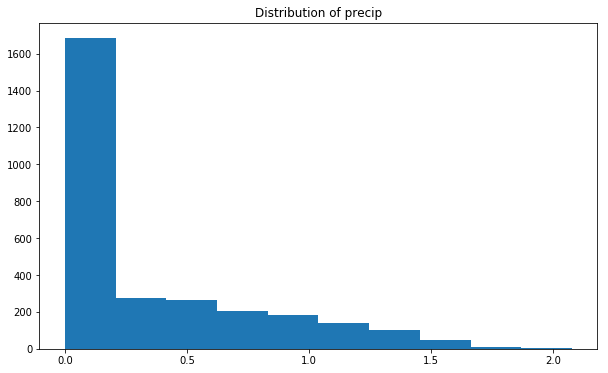

In [71]:
# plotting the distribution of precip
plt.figure(figsize=[10,6])

x = np.log10(bike_df['precip'] + 1)
plt.hist(x)
plt.title('Distribution of precip');


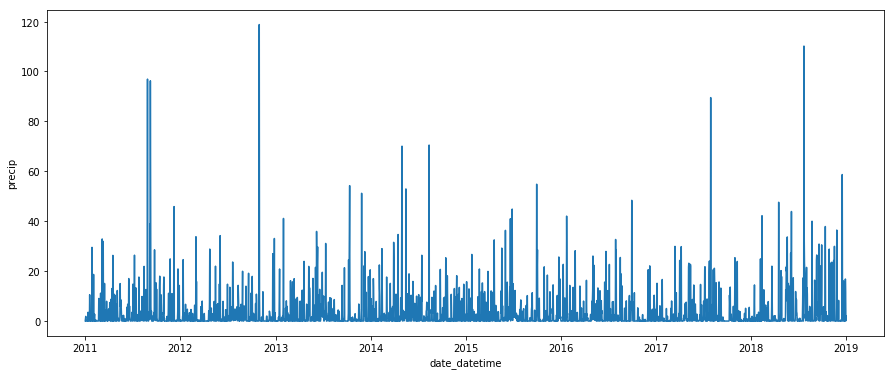

In [72]:
# plot the overall precip values for entire timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='precip', data=bike_df)


For this timeseries, I will also use a test to determine whether this timeseries is non-stationary.

In [73]:
# get the optimal number for rolling mean window
print(best_window(bike_df['precip'], bike_df['total_cust'], 30))

# get the correlation for window size determined by temp_max
precip_mean = bike_df['precip'].rolling(8).mean()[7:-1]
pearsonr(precip_mean, bike_df['total_cust'][8:])


{29: 0.1700866307778578, 1: 0.008462868123957442}


(0.0872039147256743, 2.4247240767281683e-06)

In [74]:
# get the optimal window for rolling std for temperature
print(best_window_std(bike_df['precip'], bike_df['total_cust'], 30))

# get the correlation for window size determined by temp_max
precip_mean = bike_df['precip'].rolling(8).std()[7:-1]
pearsonr(precip_mean, bike_df['total_cust'][8:])


{28: 0.08728613813774243, 1: -0.004316061084505978}


(0.03688152373482998, 0.04650923275049992)

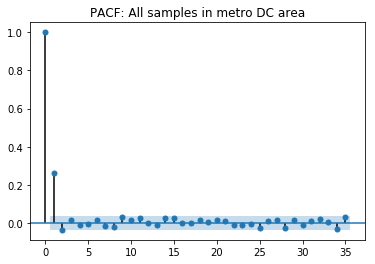

In [75]:
# plot the partial autocorrelation of precip
plot_pacf(bike_df['precip'], title='PACF: All samples in metro DC area',)
plt.show()


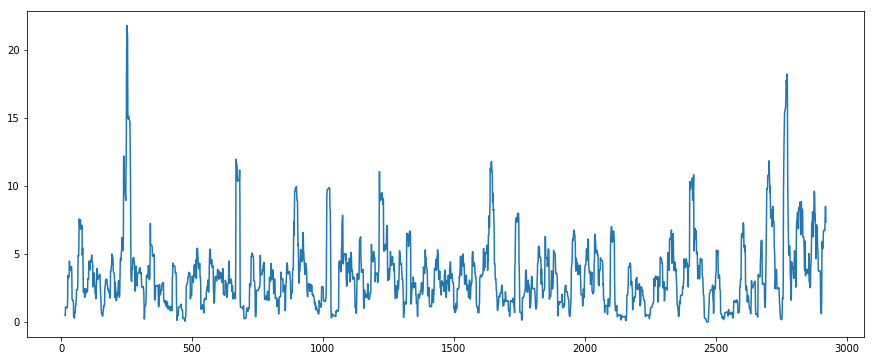

In [76]:
# create plot of rolling means
plt.figure(figsize=[15,6])

plt.plot(bike_df['precip'].rolling(16).mean());


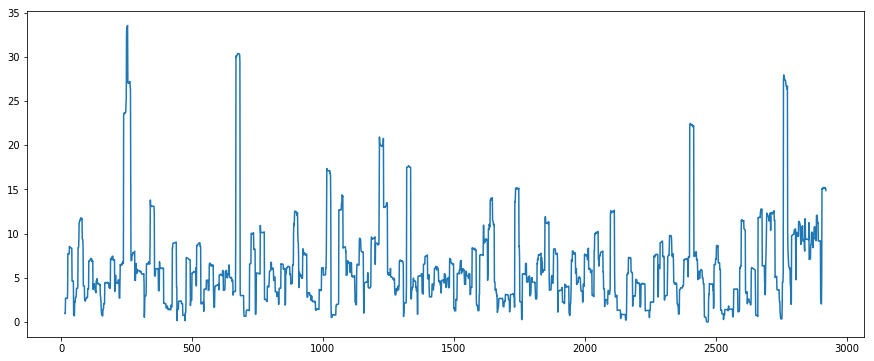

In [77]:
# create plot of rolling stds
plt.figure(figsize=[15,6])

plt.plot(bike_df['precip'].rolling(16).std());


##### wind

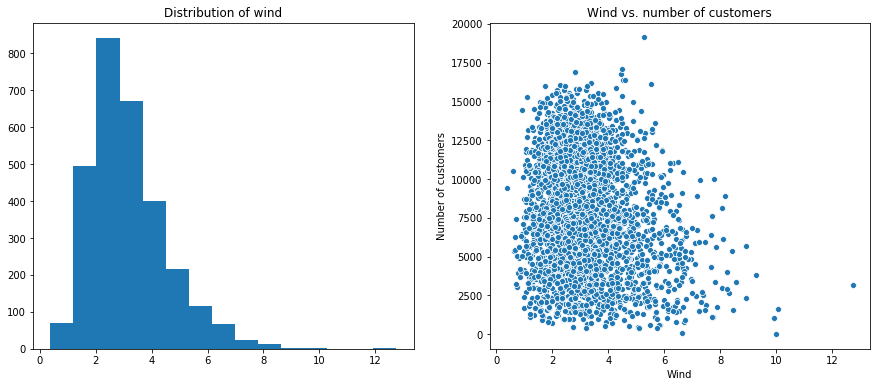

In [78]:
# plotting the distribution of wind
plt.figure(figsize=[15,6])

plt.subplot(1,2,1)
plt.hist(bike_df['wind'], bins=15)
plt.title('Distribution of wind')

plt.subplot(1,2,2)
sb.scatterplot(data = bike_df, x = 'wind', y = 'total_cust')
plt.xlabel('Wind')
plt.ylabel('Number of customers')
plt.title('Wind vs. number of customers');



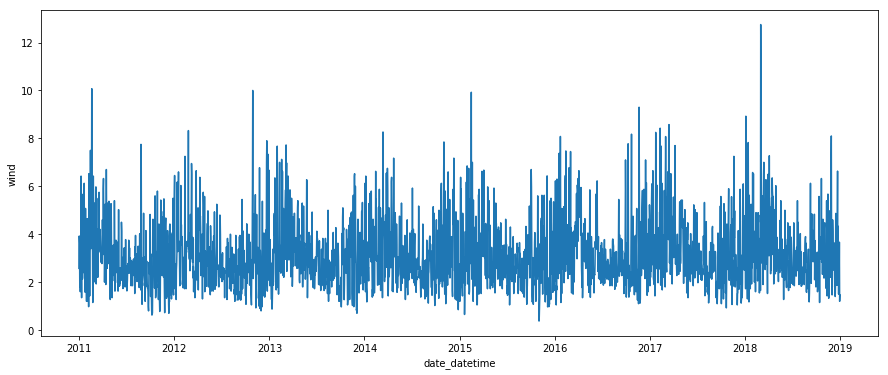

In [79]:
# plot the overall wind values for entire timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='wind', data=bike_df)


Although windspeed is only correlated with cnt in a weak sense, similar to precip, I will keep this in the model. To determine stationarity, I will use a statistical test.

In [80]:
# get the optimal number for rolling mean window
print(best_window(bike_df['wind'], bike_df['total_cust'], 30))

# get the correlation for window size determined by temp_max
wind_mean = bike_df['wind'].rolling(8).mean()[7:-1]
pearsonr(wind_mean, bike_df['total_cust'][8:])[0]


{29: -0.12193904260296493, 4: -0.1732963785331584}


-0.16774099233635734

In [81]:
# get the optimal window for rolling std for temperature
print(best_window_std(bike_df['wind'], bike_df['total_cust'], 30))

# get the correlation for window size determined by temp_max
precip_mean = bike_df['wind'].rolling(8).std()[7:-1]
pearsonr(precip_mean, bike_df['total_cust'][8:])


{1: -0.20637927533098802, 28: -0.41986595132326965}


(-0.3330155999356962, 2.082947152839517e-76)

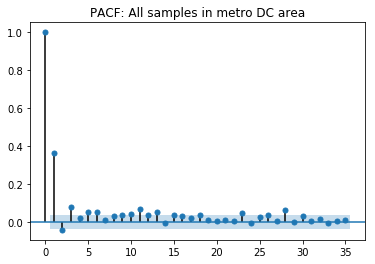

In [82]:
# plot the partial autocorrelation of wind
plot_pacf(bike_df['wind'], title='PACF: All samples in metro DC area',)
plt.show()


As I am not forecasting wind, but rather trying to understand whether wind could be able to forecast total_cust, the partial autocorrelation is not of much interest to me.

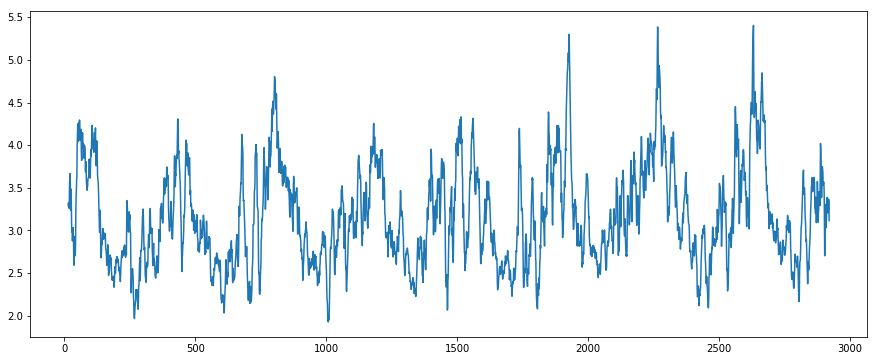

In [83]:
# create plot of rolling means
plt.figure(figsize=[15,6])

plt.plot(bike_df['wind'].rolling(16).mean());


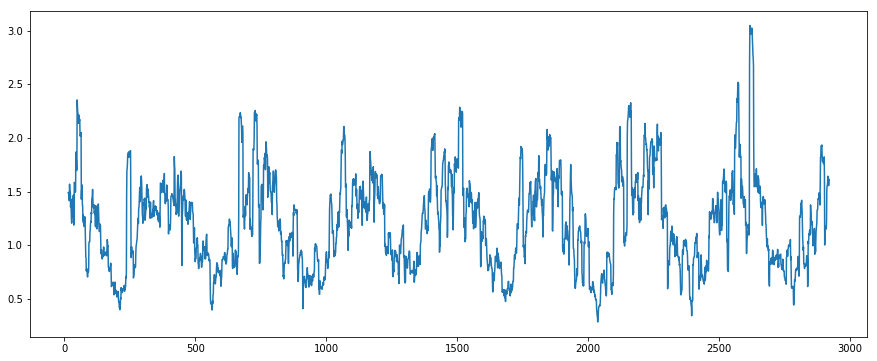

In [84]:
# create plot of rolling means
plt.figure(figsize=[15,6])

plt.plot(bike_df['wind'].rolling(16).std());


#### 2.4. Checking and dealing with stationarity

A very important part before prediction can be accurate and successful is to make the time series stationary. Examples of how to do this can be found [here](https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/) for example.

##### Augmented Dickey Fuller Test

In [85]:
# code based on implementation on https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
def adf_test(df, col_names):
    '''
    Function to perform Augmented Dickey-Fuller test on selected timeseries
    Args: df = dataframe with timeseries to be tested
          col_names = list of names of the timeseries to be tested
    Returns: None
    '''
    for name in col_names:
        print ('Results of Augmented Dickey-Fuller Test for {}'.format(name))
        result_test = adfuller(df[name], autolag='AIC')
        result_output = pd.Series(result_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key, val in result_test[4].items():
            result_output['Critical Value (%s)'%key] = val
        print (result_output)


In [86]:
# create the features that need to be tested
# total_cust_t-1 was already added to the dataframe

testing_feat = ['wind', 'precip', 'total_cust', 'temp_min', 'temp_max', 'foggy', 'ice', 'thunder', 'sleet']

testing_df = pd.DataFrame()

for col in testing_feat:
    col_mean = bike_df[col].rolling(16).mean()[15:-1]
    col_std = bike_df[col].rolling(16).std()[15:-1]
    testing_df[col+'_mean16'] = col_mean.values
    testing_df[col+'_std16'] = col_std.values


In [87]:
# adf test for total_cust_t-1
temp_cust_1 = bike_df['total_cust_t-1'].fillna(0)
bike_df_temp = pd.DataFrame(temp_cust_1, columns=['total_cust_t-1'])
adf_test(bike_df_temp, ['total_cust_t-1'])


Results of Augmented Dickey-Fuller Test for total_cust_t-1
Test Statistic                   -3.085391
p-value                           0.027653
#Lags Used                       22.000000
Number of Observations Used    2899.000000
Critical Value (1%)              -3.432608
Critical Value (5%)              -2.862538
Critical Value (10%)             -2.567301
dtype: float64


In [88]:
# adf test for total_cust
adf_test(bike_df, ['total_cust'])


Results of Augmented Dickey-Fuller Test for total_cust
Test Statistic                   -3.068277
p-value                           0.028992
#Lags Used                       22.000000
Number of Observations Used    2899.000000
Critical Value (1%)              -3.432608
Critical Value (5%)              -2.862538
Critical Value (10%)             -2.567301
dtype: float64


In [89]:
# adf test for all engineered features
adf_test(testing_df, testing_df.columns)


Results of Augmented Dickey-Fuller Test for wind_mean16
Test Statistic                   -5.565211
p-value                           0.000002
#Lags Used                       28.000000
Number of Observations Used    2877.000000
Critical Value (1%)              -3.432625
Critical Value (5%)              -2.862545
Critical Value (10%)             -2.567305
dtype: float64
Results of Augmented Dickey-Fuller Test for wind_std16
Test Statistic                   -5.043268
p-value                           0.000018
#Lags Used                       17.000000
Number of Observations Used    2888.000000
Critical Value (1%)              -3.432616
Critical Value (5%)              -2.862541
Critical Value (10%)             -2.567303
dtype: float64
Results of Augmented Dickey-Fuller Test for precip_mean16
Test Statistic                -8.653592e+00
p-value                        5.038219e-14
#Lags Used                     2.700000e+01
Number of Observations Used    2.878000e+03
Critical Value (1%)    

Null hypothesis: data is not stationary

Alternative hypothesis: data is stationary

The results of the ADF Test can be intepreted as follows:
* test-statistic < critical value --> reject null hypothesis (data is stationary)
* test_statistic > critical value --> fail to reject null hypothesis (data is not stationary)

Based on these results, total_cust, total_cust_t-1 and total_cust_mean16 are not stationary at the 1%-level. This test does not look at the trend stationarity but rather at the difference stationarity. This means that total_cust_t-1 and total_cust_mean16 are **not difference stationary** at the 1%-level. The KPSS test is necessary to detemine the trend stationarity of the timeseries.
    

##### Kwiatkowski-Phillips-Schmidt-Shin Test

In [90]:
# code based on implementation on https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
def kpss_test(df, col_names):
    '''
    Function to perform KPSS test on selected timeseries
    Args: df = dataframe with timeseries to be tested
          col_names = list of names of the timeseries to be tested
    Returns: None
    '''
    for name in col_names:
        print ('Results of KPSS Test for {}'.format(name))
        result_test = kpss(df[name], regression='c', lags='legacy')
        result_output = pd.Series(result_test[0:3], index=['Test Statistic','p-value','Lags Used'])
        for key, val in result_test[3].items():
            result_output['Critical Value (%s)'%key] = val
        print (result_output)

# kpss test for total_cust
kpss_test(testing_df, testing_df.columns)


Results of KPSS Test for wind_mean16
Test Statistic            0.361757
p-value                   0.093639
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for wind_std16
Test Statistic            0.066393
p-value                   0.100000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for precip_mean16
Test Statistic            0.190685
p-value                   0.100000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for precip_std16
Test Statistic            0.12816
p-value                   0.10000
La

C:\Users\julia\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\julia\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\julia\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\julia\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\julia\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-va

In [91]:
# kpss test for total_cust_t-1
kpss_test(bike_df_temp, ['total_cust_t-1'])

# kpss test for total_cust
kpss_test(bike_df, ['total_cust'])


Results of KPSS Test for total_cust_t-1


C:\Users\julia\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\julia\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Test Statistic            4.452604
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for total_cust
Test Statistic            4.430839
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Null hypothesis: data is stationary

Alternative hypothesis: data is not stationary

The results of the KPSS Test can be intepreted as follows:
* test-statistic > critical value --> reject null hypothesis (data is not stationary)
* test_statistic < critical value --> fail to reject null hypothesis (data is stationary)

Based on these results, all total_cust and rain features are not trend stationary at the 1%-level.

This has the following implications for the evaluated timeseries:
* difference and trend stationary: **no** transformations are needed
* difference stationary and **not** trend stationary: total_cust_std16 --> transformations needed
* **not** difference stationary but trend stationary: total_cust --> transformations needed
* **not** difference and **not** trend stationary: total_cust_mean16, total_cust_t-1 --> transformations needed
    

##### Trend


In [92]:
# Removing positive upward trend from total_cust_mean16, total_cust_std16 and total_cust_t-1
testing_df['total_cust_std16_log'] = [np.log1p(x+1) for x in testing_df['total_cust_std16']]
testing_df['total_cust_mean16_log'] = [np.log1p(x+1) for x in testing_df['total_cust_mean16']]
bike_df_temp['total_cust_t-1_log'] = [np.log1p(x+1) for x in bike_df_temp['total_cust_t-1']]


#### Differencing

In [93]:
# applying differencing to remove trend from total_cust
bike_df_check = bike_df[['total_cust']]
bike_df_check['total_cust_diff'] = bike_df_check['total_cust'] - bike_df_check['total_cust'].shift()
bike_df_check = bike_df_check.iloc[1:,]

C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [94]:
# kpss test for total_cust
kpss_test(testing_df, ['total_cust_std16_log', 'total_cust_mean16_log'])
kpss_test(bike_df_temp, ['total_cust_t-1_log'])

# adf test for total_cust
adf_test(testing_df, ['total_cust_std16_log', 'total_cust_mean16_log'])
adf_test(bike_df_temp, ['total_cust_t-1_log'])
adf_test(bike_df_check, ['total_cust_diff'])


Results of KPSS Test for total_cust_std16_log
Test Statistic            6.328651
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for total_cust_mean16_log
Test Statistic            4.412647
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for total_cust_t-1_log
Test Statistic            4.013791
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of Augmented Dickey-Fuller Test for total_cust_std16_log


C:\Users\julia\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\julia\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\julia\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Test Statistic                   -4.578370
p-value                           0.000142
#Lags Used                       16.000000
Number of Observations Used    2889.000000
Critical Value (1%)              -3.432616
Critical Value (5%)              -2.862541
Critical Value (10%)             -2.567303
dtype: float64
Results of Augmented Dickey-Fuller Test for total_cust_mean16_log
Test Statistic                   -3.959044
p-value                           0.001641
#Lags Used                       28.000000
Number of Observations Used    2877.000000
Critical Value (1%)              -3.432625
Critical Value (5%)              -2.862545
Critical Value (10%)             -2.567305
dtype: float64
Results of Augmented Dickey-Fuller Test for total_cust_t-1_log
Test Statistic                   -3.902610
p-value                           0.002016
#Lags Used                       26.000000
Number of Observations Used    2895.000000
Critical Value (1%)              -3.432611
Critical Value (5%)     

The transformations I implemented above can be used later on to make the timeseries stationary. I will create classes to make the necessary transformations inside the ML pipeline.

#### 2.6. Feature Selection

Based on the EDA above, I will choose the following features
* holiday: t0
* weekdays: each day at t0
* workingday: t0
* temp_max: rolling mean for 8 days
* temp_max: rolling std for 8 days
* temp_min:rolling mean for 8 days
* temp_min: rolling std for 8 days
* season_spring: t0
* season_summer: t0
* season_fall: t0
* very cold, cold, cool, warm, hot: t-1
* foggy, thunder, ice, sleet: rolling mean and std for 8 days
* wind: rolling mean for 8 days
* wind: rolling std for 8 days
* precip: rolling mean for 8 days
* precip: rolling std for 8 days
* total_cust: t-1
* total_cust: rolling mean for 8 days
* total_cust: rolling std for 8 days


### 3. Data Preparation

#### 3.1. Dropping unnecessary columns

I am only going to remove any columns which I no longer need and split the dataframes into X and y.

In [95]:
# should keep this before the cleaning function has been created
bike_df.drop(columns=['temp_observ', 'weekday'], axis=1, inplace=True)


In [96]:
# drop the timestamp variable
bike_df.drop(columns=['date_datetime'], inplace=True)


#### 3.2. Creating new features

In [97]:
# specify the window for rolling values
window = 8


In [98]:
# engineer new categorical temp features
bike_df_cat = bike_df[['temp_max']].copy()
bike_df_cat['very_cold'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 0 else 0)
bike_df_cat['cold'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 10 and x >= 0 else 0)
bike_df_cat['cool'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 20 and x >= 10 else 0)
bike_df_cat['warm'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 30 and x >= 20 else 0)
bike_df_cat['hot'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x >= 30 else 0)

bike_df_cat[['very_cold', 'cold', 'cool', 'warm', 'hot']] = bike_df_cat[['very_cold', 'cold', 'cool', 'warm', 'hot']].shift()

bike_df_cat.drop(columns=['temp_max'], inplace=True)


In [99]:
# creating rolling values
new_feat = ['wind', 'precip', 'total_cust', 'temp_max', 'temp_min', 'foggy', 'ice', 'thunder', 'sleet']

temp_df = pd.DataFrame()

for col in new_feat:
    col_mean = bike_df[col].rolling(window).mean()[(window-1):-1]
    col_std = bike_df[col].rolling(window).std()[(window-1):-1]
    temp_df[col+'_mean'+str(window)] = col_mean.values
    temp_df[col+'_std'+str(window)] = col_std.values


In [100]:
# remember to remove the first row from 16 rows from total_cust (target label)
new_bike_df = bike_df.iloc[window:,:]
bike_df_cat = bike_df_cat.iloc[window:,:]
new_bike_df.reset_index(drop=True, inplace=True)
bike_df_cat.reset_index(drop=True, inplace=True)
new_bike_df.head()


,temp_min,temp_max,precip,wind,total_cust,holiday,season_spring,season_summer,season_fall,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,working_day,foggy,thunder,ice,sleet,total_cust_t-1
0,-6.293333,0.226667,0.283529,6.425,802.0,0.0,1,0,0,0,0,0,0,0,1,0.0,1,0.0,0,0,939.0
1,-6.238462,0.507692,0.000000,2.975,1298.0,0.0,1,0,0,0,0,0,0,0,0,0.0,1,0.0,0,0,802.0
2,-5.914286,0.564286,0.460241,1.350,1231.0,0.0,1,0,0,1,0,0,0,0,0,1.0,1,0.0,1,1,1298.0
3,-5.114286,0.192857,3.526882,5.675,1141.0,0.0,1,0,0,0,1,0,0,0,0,1.0,1,0.0,0,1,1231.0
4,-4.600000,1.035714,0.000000,5.025,1383.0,0.0,1,0,0,0,0,1,0,0,0,1.0,1,0.0,0,0,1141.0


In [101]:
# drop all columns which we cannot use because of lookahead bias
new_bike_df.drop(columns=['temp_max', 'wind', 'temp_min', 'precip', 
                          'thunder', 'foggy', 'ice', 'sleet'], inplace=True)


C:\Users\julia\Anaconda3\lib\site-packages\pandas\core\frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [102]:
# merging both dataframes with features
final_bike_df = new_bike_df.join(temp_df, how='left')
final_bike_df = final_bike_df.join(bike_df_cat, how='left')
final_bike_df.head()


,total_cust,holiday,season_spring,season_summer,season_fall,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,working_day,total_cust_t-1,wind_mean8,wind_std8,precip_mean8,precip_std8,total_cust_mean8,total_cust_std8,temp_max_mean8,temp_max_std8,temp_min_mean8,temp_min_std8,foggy_mean8,foggy_std8,ice_mean8,ice_std8,thunder_mean8,thunder_std8,sleet_mean8,sleet_std8,very_cold,cold,cool,warm,hot
0,802.0,0.0,1,0,0,0,0,0,0,0,1,0.0,939.0,2.950000,1.034581,0.421471,0.684656,1269.125,327.163759,6.447202,4.510609,-3.404881,2.142402,0.500,0.534522,0.125,0.353553,0.0,0.0,0.375,0.517549,0.0,1.0,0.0,0.0,0.0
1,1298.0,0.0,1,0,0,0,0,0,0,0,0,0.0,802.0,3.431250,1.584509,0.448246,0.673007,1249.500,352.176904,4.978869,4.364272,-3.995714,2.213616,0.500,0.534522,0.125,0.353553,0.0,0.0,0.375,0.517549,0.0,1.0,0.0,0.0,0.0
2,1231.0,0.0,1,0,0,1,0,0,0,0,0,1.0,1298.0,3.312500,1.577804,0.318577,0.642533,1314.125,297.044700,3.316497,2.758924,-4.885522,1.147913,0.500,0.534522,0.125,0.353553,0.0,0.0,0.375,0.517549,0.0,1.0,0.0,0.0,0.0
3,1141.0,0.0,1,0,0,0,1,0,0,0,0,1.0,1231.0,3.028125,1.712686,0.141254,0.178921,1305.375,298.513909,2.453997,2.320742,-5.194451,1.030777,0.625,0.517549,0.250,0.462910,0.0,0.0,0.500,0.534522,0.0,1.0,0.0,0.0,0.0
4,1383.0,0.0,1,0,0,0,0,1,0,0,0,1.0,1141.0,3.512500,1.857562,0.582114,1.201888,1256.000,287.377800,1.897747,2.253481,-5.089093,0.983683,0.750,0.462910,0.250,0.462910,0.0,0.0,0.625,0.517549,0.0,1.0,0.0,0.0,0.0


#### 3.3. Assinging X and y

In [103]:
# assigning X and y
y = final_bike_df['total_cust']
X = final_bike_df.drop(columns=['total_cust'])


### 4. Model

#### 4.1. Creating transformation classes

In [104]:
# creating a class that I can use in the ML pipeline that prints out the transformed data that will enter the model
class Debug(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        self.shape = X.shape
        print(self.shape)
        X_df = pd.DataFrame(X)
        print(X_df)
        # print(X_df.to_string()) # can only be print like this without running LagVars() to avoid crashing
        # what other output you want
        return X
    

#### 4.2. Baseline model: naive univariate prediction

When using autoregression models, we're only focusing on the target variable and aim to predict this variable with it previous values.

In [105]:
# assigning X and y for the univariate naive prediction
y_naive = (final_bike_df['total_cust'].copy())
X_naive = y_naive.copy()
X_naive = pd.DataFrame(data=X_naive, columns=['total_cust'])
y_pred = (X_naive.shift())[1:]
y_naive = y_naive[1:]


In [106]:
# calculating the scores for the last value method
print('RMSE:', np.sqrt(mean_squared_error(y_naive, y_pred)))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_naive, y_pred)))
print('MAE:', mean_absolute_error(y_naive, y_pred))


RMSE: 2092.6809614099934
RMSLE: 0.40731742102103863
MAE: 1403.2437349811191


#### Preparation code for using differenced y for predictions

In [107]:
y_log = final_bike_df[['total_cust']].copy()
y_log['total_cust'] = y_log['total_cust'].apply(lambda x: np.log1p(x+1))
y_shift = y_log.shift(1)
y_diff = (y_log - y_shift)[1:]
X_diff = X[1:]

y_diff.reset_index(drop=True, inplace=True)
X_diff.reset_index(drop=True, inplace=True)


In [108]:
# initializing the model which is a Random Forest model and uses default hyperparameters
model_rf_diff = RandomForestRegressor(random_state=42)


In [109]:
# creating and fitting the ML pipeline
trend_features = ['total_cust_mean'+str(window), 'total_cust_std'+str(window), 'total_cust_t-1']

preprocessor = ColumnTransformer([
    ('trend_diff', FunctionTransformer(np.log1p, validate=False), trend_features),
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('debug', Debug()) # I have commented this out because it will hinder the execution of this pipeline
    ('model', model_rf_diff)
])

pipeline_rf_diff = pipeline.fit(X_diff, y_diff)


C:\Users\julia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\julia\Anaconda3\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [110]:
# creating a timeseries split of the datasets
time_split = TimeSeriesSplit(n_splits=10)

# doing cross validation on the chunks of data and calculating scores
scores_rf_diff = cross_validate(pipeline_rf_diff, X_diff, y_diff, cv=time_split,
                         scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
                         return_train_score=True, n_jobs=-1)


In [111]:
# root mean squared error
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_rf_diff['train_neg_mean_squared_error']])/len(scores_rf_diff['train_neg_mean_squared_error']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_rf_diff['test_neg_mean_squared_error']])/len(scores_rf_diff['test_neg_mean_squared_error']))

# root mean squared log error
print('Average root mean squared error train data:', 
      sum([(-1 * x) for x in scores_rf_diff['train_neg_mean_absolute_error']])/len(scores_rf_diff['train_neg_mean_absolute_error']))
print('Average root mean squared error test data:', 
      sum([(-1 * x) for x in scores_rf_diff['test_neg_mean_absolute_error']])/len(scores_rf_diff['test_neg_mean_absolute_error']))


Average root mean squared error train data: 0.15921998273560453
Average root mean squared error test data: 0.3933042179673459
Average root mean squared error train data: 0.08967611521493404
Average root mean squared error test data: 0.27363243643530427


In [112]:
X_train_over = defaultdict()  
X_test_over = defaultdict()
y_train_over = defaultdict()
y_test_over = defaultdict()

y_test_index = []
y_train_index = []

count = 0

for train_index, test_index in time_split.split(X_diff):
    print("TRAIN:", train_index, "TEST:", test_index)
    
    y_test_index.append(test_index)
    y_train_index.append(train_index)
    
    X_train, X_test = X_diff.iloc[train_index], X_diff.iloc[test_index]
    y_train, y_test = (np.array(y_diff))[train_index], (np.array(y_diff))[test_index]
    X_train_over[count] = X_train
    X_test_over[count] = X_test
    y_train_over[count] = y_train
    y_test_over[count] = y_test
    
    count += 1

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

In [113]:
def split_predict_test(X_train, y_train, X_test, y_test, split):
    
    pipeline_part = pipeline.fit(X_train[split], y_train[split].ravel())
    prediction_test = pipeline_part.predict(X_test[split])
    #print('transformed RMSE:', np.sqrt(mean_squared_error(y_test[split], prediction_test)))
        
    # what are the predictions in absolute terms
    y_test_pred_log = prediction_test + y_log.iloc[y_test_index[split]]['total_cust']
    y_test_pred = np.exp(y_test_pred_log) - 2

    # what are the actual values in absolute terms
    y_test_true_log = y_test[split] + y_log.iloc[y_test_index[split]]
    y_test_true = np.exp(y_test_true_log) - 2 # minus 2 because we added 1 each when doing the log function earlier

    # what is the rmse, rmsle and mae
    #print('actual RMSE:', np.sqrt(mean_squared_error(y_test_true, y_test_pred)))
    #print('actual RMSLE:', np.sqrt(mean_squared_log_error(y_test_true, y_test_pred)))
    #print('actual MAE:', mean_absolute_error(y_test_true, y_test_pred))
    
    rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_test_true, y_test_pred))
    mae = mean_absolute_error(y_test_true, y_test_pred)
    
    list_scores = []
    list_scores.extend([rmse, rmsle, mae])
    
    return list_scores


In [114]:
def split_predict_train(X_train, y_train, X_test, y_test, split):
    
    pipeline_part = pipeline.fit(X_train[split], y_train[split].ravel())
    prediction_train = pipeline_part.predict(X_train[split])
    #print('transformed RMSE:', np.sqrt(mean_squared_error(y_test[split], prediction_test)))
        
    # what are the predictions in absolute terms
    y_train_pred_log = prediction_train + y_log.iloc[y_train_index[split]]['total_cust']
    y_train_pred = np.exp(y_train_pred_log) - 2

    # what are the actual values in absolute terms
    y_train_true_log = y_train[split] + y_log.iloc[y_train_index[split]]
    y_train_true = np.exp(y_train_true_log) - 2 # minus 2 because we added 1 each when doing the log function earlier

    # what is the rmse, rmsle and mae
    #print('actual RMSE:', np.sqrt(mean_squared_error(y_test_true, y_test_pred)))
    #print('actual RMSLE:', np.sqrt(mean_squared_log_error(y_test_true, y_test_pred)))
    #print('actual MAE:', mean_absolute_error(y_test_true, y_test_pred))
    
    rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_train_true, y_train_pred))
    mae = mean_absolute_error(y_train_true, y_train_pred)
    
    list_scores = []
    list_scores.extend([rmse, rmsle, mae])
    
    return list_scores

#### 4.4. Random Forests

##### doing run through with untransformed y

In [115]:
# initializing the model which is a Random Forest model and uses default hyperparameters
model_rf = RandomForestRegressor(random_state=15)


In [116]:
# creating and fitting the ML pipeline
trend_features = ['total_cust_mean'+str(window), 'total_cust_std'+str(window), 'total_cust_t-1']

preprocessor = ColumnTransformer([
    ('trend_diff', FunctionTransformer(np.log1p, validate=False), trend_features),
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('debug', Debug()) # I have commented this out because it will hinder the execution of this pipeline
    ('model', model_rf)
])

pipeline_rf = pipeline.fit(X, y)


C:\Users\julia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [117]:
# creating a timeseries split of the datasets
time_split = TimeSeriesSplit(n_splits=10)

# doing cross validation on the chunks of data and calculating scores
scores_rf = cross_validate(pipeline_rf, X, y, cv=time_split,
                         scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                                  'neg_mean_squared_log_error'],
                         return_train_score=True, n_jobs=-1)


In [118]:
# root mean squared error
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_rf['train_neg_mean_squared_error']])/len(scores_rf['train_neg_mean_squared_error']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_rf['test_neg_mean_squared_error']])/len(scores_rf['test_neg_mean_squared_error']))

# root mean squared log error
print('Average root mean squared error train data:', 
      sum([(-1 * x) for x in scores_rf['train_neg_mean_absolute_error']])/len(scores_rf['train_neg_mean_absolute_error']))
print('Average root mean squared error test data:', 
      sum([(-1 * x) for x in scores_rf['test_neg_mean_absolute_error']])/len(scores_rf['test_neg_mean_absolute_error']))

# root mean squared log error
print('Average root mean squared error train data:', 
      sum([(-1 * x) for x in scores_rf['train_neg_mean_squared_log_error']])/len(scores_rf['train_neg_mean_squared_log_error']))
print('Average root mean squared error test data:', 
      sum([(-1 * x) for x in scores_rf['test_neg_mean_squared_log_error']])/len(scores_rf['test_neg_mean_squared_log_error']))


Average root mean squared error train data: 562.8630885271843
Average root mean squared error test data: 2198.4252526779046
Average root mean squared error train data: 368.8194312056886
Average root mean squared error test data: 1732.4655303030304
Average root mean squared error train data: 0.035522261021610255
Average root mean squared error test data: 0.14941839849134012


I will use randomizedsearch and gridsearch to tune my hyperparameters for the Random Forest model.

In [119]:
# number of trees in random forest
n_estimators = randint(1, 2000)
# maximum number of features included in the model
max_features = randint(1, 20)
# maximum number of levels in tree
max_depth = randint(1,10)
# minimum number of samples required to split a node
min_samples_leaf = randint(1, 10)

# create the random grid
random_grid_rf = {'model__n_estimators': n_estimators,
                   'model__max_depth': max_depth,
                   'model__min_samples_leaf': min_samples_leaf,
                   'model__max_features': max_features}


I'm using a try and except argument to load an already tuned model or, if none is available, to run randomsearch.

In [134]:
# check the start time
start_time = datetime.now()
print(start_time)

# instantiate and fit the randomizedsearch class to the random parameters
rs_rf = RandomizedSearchCV(pipeline_rf, 
                        param_distributions=random_grid_rf, 
                        scoring='neg_mean_squared_error', 
                        n_jobs=-1,
                        cv=time_split,
                        n_iter = 5,
                        verbose=10,
                        random_state=49)
rs_rf = rs_rf.fit(X, y)

# print the total running time
end_time = datetime.now()
print('Total running time:', end_time-start_time)


2020-01-13 11:14:36.870514
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.3min finished


Total running time: 0:02:58.000362


In [136]:
# Saving the best RandomForest model
pickle.dump(rs_rf.best_estimator_, open('randomforest.sav', 'wb'))

# change the keys of the best_params dictionary to allow it to be used for the final model
fix_best_params_rf = {key[7:]: val for key, val in rs_rf.best_params_.items()}

print(fix_best_params_rf)

# fit the randomforestregressor with the best_params as hyperparameters
model_rf_rs = RandomForestRegressor(**fix_best_params_rf)


{'max_depth': 9, 'max_features': 19, 'min_samples_leaf': 6, 'n_estimators': 1926}


In [137]:
# creating and fitting the ML pipeline
trend_features = ['total_cust_mean'+str(window), 'total_cust_std'+str(window), 'total_cust_t-1']

preprocessor = ColumnTransformer([
    ('trend_diff', FunctionTransformer(np.log1p, validate=False), trend_features),
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('debug', Debug()) # I have commented this out because it will hinder the execution of this pipeline
    ('model', model_rf_rs)
])

# fitting x and y to pipeline
pipeline_rf_rs = pipeline.fit(X, y)


In [138]:
# doing cross validation on the chunks of data and calculating scores
scores_rf = cross_validate(pipeline_rf_rs, X, y, cv=time_split,
                         scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                                  'neg_mean_squared_log_error'],
                         return_train_score=True, n_jobs=-1)


In [139]:
# root mean squared error
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_rf['train_neg_mean_squared_error']])/len(scores_rf['train_neg_mean_squared_error']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_rf['test_neg_mean_squared_error']])/len(scores_rf['test_neg_mean_squared_error']))

# root mean squared log error
print('Average root mean squared error train data:', 
      sum([(-1 * x) for x in scores_rf['train_neg_mean_absolute_error']])/len(scores_rf['train_neg_mean_absolute_error']))
print('Average root mean squared error test data:', 
      sum([(-1 * x) for x in scores_rf['test_neg_mean_absolute_error']])/len(scores_rf['test_neg_mean_absolute_error']))

# root mean squared log error
print('Average root mean squared error train data:', 
      sum([(-1 * x) for x in scores_rf['train_neg_mean_squared_log_error']])/len(scores_rf['train_neg_mean_squared_log_error']))
print('Average root mean squared error test data:', 
      sum([(-1 * x) for x in scores_rf['test_neg_mean_squared_log_error']])/len(scores_rf['test_neg_mean_squared_log_error']))


Average root mean squared error train data: 925.444261695286
Average root mean squared error test data: 1992.5979291515505
Average root mean squared error train data: 640.8612929066818
Average root mean squared error test data: 1571.4945872926455
Average root mean squared error train data: 0.08017668110238532
Average root mean squared error test data: 0.13568691390360926


In [147]:
# assign lists of parameters to be used in gridsearch
param_grid_rf = {'model__max_depth': [8, 9],
                 'model__max_features': [18, 19],
                 'model__min_samples_leaf': [5, 6],
                 'model__n_estimators': [1926, 1930]
}


In [148]:
# use gridsearch to search around the randomizedsearch best parameters and further improve the model
gs_rf = GridSearchCV(pipeline_rf, 
                  param_grid=param_grid_rf, 
                  scoring='neg_mean_squared_error', 
                  verbose = 10,
                  n_jobs=-1, 
                  cv=time_split)
gs_rf = gs_rf.fit(X, y)


Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 19.9min finished


In [149]:
# Saving the best RandomForest model
pickle.dump(gs_rf.best_estimator_, open('randomforest.sav', 'wb'))

# change the keys of the best_params dictionary to allow it to be used for the final model
fix_best_params_rf = {key[7:]: val for key, val in gs_rf.best_params_.items()}

print(fix_best_params_rf)

# fit the randomforestregressor with the best_params as hyperparameters
model_rf_tuned = RandomForestRegressor(**fix_best_params_rf)


{'max_depth': 9, 'max_features': 19, 'min_samples_leaf': 6, 'n_estimators': 1926}


In [150]:
# creating and fitting the ML pipeline
trend_features = ['total_cust_mean'+str(window), 'total_cust_std'+str(window), 'total_cust_t-1']

preprocessor = ColumnTransformer([
    ('trend_diff', FunctionTransformer(np.log1p, validate=False), trend_features),
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('debug', Debug()) # I have commented this out because it will hinder the execution of this pipeline
    ('model', model_rf_tuned)
])

# fitting x and y to pipeline
pipeline_rf_tuned = pipeline.fit(X, y)


In [155]:
# check the start time
start_time = datetime.now()

# doing cross validation on the chunks of data and calculating scores
scores_rf_tuned = cross_validate(pipeline_rf_tuned, X, y, cv=time_split,
                         scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                                  'neg_mean_squared_log_error'],
                         return_train_score=True, n_jobs=-1)

# print the total running time
end_time = datetime.now()
print('Total cross validation time for random forests:', (end_time-start_time).total_seconds())


Total cross validation time for random forests: 100.53016


In [156]:
# root mean squared error
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_rf_tuned['train_neg_mean_squared_error']])/len(scores_rf_tuned['train_neg_mean_squared_error']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_rf_tuned['test_neg_mean_squared_error']])/len(scores_rf_tuned['test_neg_mean_squared_error']))

# root mean squared log error
print('Average root mean squared error train data:', 
      sum([(-1 * x) for x in scores_rf_tuned['train_neg_mean_absolute_error']])/len(scores_rf_tuned['train_neg_mean_absolute_error']))
print('Average root mean squared error test data:', 
      sum([(-1 * x) for x in scores_rf_tuned['test_neg_mean_absolute_error']])/len(scores_rf_tuned['test_neg_mean_absolute_error']))

# root mean squared log error
print('Average root mean squared error train data:', 
      sum([(-1 * x) for x in scores_rf_tuned['train_neg_mean_squared_log_error']])/len(scores_rf_tuned['train_neg_mean_squared_log_error']))
print('Average root mean squared error test data:', 
      sum([(-1 * x) for x in scores_rf_tuned['test_neg_mean_squared_log_error']])/len(scores_rf_tuned['test_neg_mean_squared_log_error']))



Average root mean squared error train data: 925.1253900821459
Average root mean squared error test data: 1993.2333464062972
Average root mean squared error train data: 640.8663970013424
Average root mean squared error test data: 1571.0803928596047
Average root mean squared error train data: 0.08012344158663812
Average root mean squared error test data: 0.1356910715781889


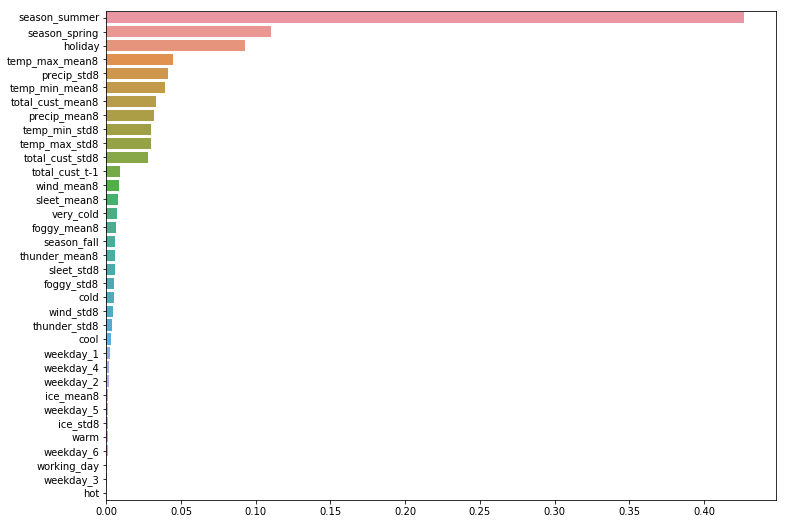

In [157]:
# plot feature importance
plt.figure(figsize=[12,9])
importances = list(pipeline_rf_tuned.steps[1][1].feature_importances_)

imp_dict = {key: val for key, val in zip(list(X.columns), importances)}
sorted_feats = sorted(imp_dict.items(), key=lambda x:x[1], reverse=True)
x_val = [x[0] for x in sorted_feats]
y_val = [x[1] for x in sorted_feats]

sb.barplot(y_val, x_val)


##### running model with differenced y

In [154]:
# get the final scores for the differenced data
split = 10
all_scores_test = []
all_scores_train = []

for i in range(split):
    scores_test = split_predict_test(X_train_over, y_train_over, X_test_over, y_test_over, i)
    all_scores_test.append(scores_test)
    scores_train = split_predict_train(X_train_over, y_train_over, X_test_over, y_test_over, i)
    all_scores_train.append(scores_train)
    
rmse_test = []
rmsle_test = []
mae_test = []
rmse_train = []
rmsle_train = []
mae_train = []

for vals in all_scores_test:
    rmse_test.append(vals[0])
    rmsle_test.append(vals[1])
    mae_test.append(vals[2])
    
for vals in all_scores_train:
    rmse_train.append(vals[0])
    rmsle_train.append(vals[1])
    mae_train.append(vals[2])
    
print('Overall Test RMSE:', sum(rmse_test)/split)
print('Overall Test RMSLE:', sum(rmsle_test)/split)
print('Overall Test MAE:', sum(mae_test)/split)

print('Overall Train RMSE:', sum(rmse_train)/split)
print('Overall Train RMSLE:', sum(rmsle_train)/split)
print('Overall Train MAE:', sum(mae_train)/split)
    

Overall Test RMSE: 1995.9855244367147
Overall Test RMSLE: 0.36478306252199444
Overall Test MAE: 1516.678483172097
Overall Train RMSE: 1111.3228215520805
Overall Train RMSLE: 0.2882879863023406
Overall Train MAE: 783.8346481381517


##### Removing some features based on feature importance

In [158]:
# how many features are in the dataset currently:
len(x_val)
weekday_feats = ['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'hot']

In [159]:
# check how the model performance without certain features that are very unimportant
X_feat_imp = X.drop(columns=weekday_feats)


In [160]:
# creating and fitting the ML pipeline
trend_features = ['total_cust_mean'+str(window), 'total_cust_std'+str(window)]#, 'total_cust_t-1']

preprocessor = ColumnTransformer([
    ('trend_diff', FunctionTransformer(np.log1p, validate=False), trend_features),
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('debug', Debug()) # I have commented this out because it will hinder the execution of this pipeline
    ('model', model_rf_tuned)
])

# fitting x and y to pipeline
pipeline_rf_tuned = pipeline.fit(X_feat_imp, y)


In [161]:
# doing cross validation on the chunks of data and calculating scores
scores_rf_tuned = cross_validate(pipeline_rf_tuned, X_feat_imp, y, cv=time_split,
                         scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                                  'neg_mean_squared_log_error'],
                         return_train_score=True, n_jobs=-1)


In [162]:
# root mean squared error
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_rf_tuned['train_neg_mean_squared_error']])/len(scores_rf_tuned['train_neg_mean_squared_error']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_rf_tuned['test_neg_mean_squared_error']])/len(scores_rf_tuned['test_neg_mean_squared_error']))

# mean absolute error
print('Average mean absolute error train data:', 
      sum([(-1 * x) for x in scores_rf_tuned['train_neg_mean_absolute_error']])/len(scores_rf_tuned['train_neg_mean_absolute_error']))
print('Average mean absolute error test data:', 
      sum([(-1 * x) for x in scores_rf_tuned['test_neg_mean_absolute_error']])/len(scores_rf_tuned['test_neg_mean_absolute_error']))

# root mean squared log error
print('Average root mean squared log error train data:', 
      sum([(-1 * x) for x in scores_rf_tuned['train_neg_mean_squared_log_error']])/len(scores_rf_tuned['train_neg_mean_squared_log_error']))
print('Average root mean squared log error test data:', 
      sum([(-1 * x) for x in scores_rf_tuned['test_neg_mean_squared_log_error']])/len(scores_rf_tuned['test_neg_mean_squared_log_error']))



Average root mean squared error train data: 918.301493480845
Average root mean squared error test data: 1988.7157957649383
Average mean absolute error train data: 635.596113890861
Average mean absolute error test data: 1564.0198911840735
Average root mean squared log error train data: 0.07915913673718417
Average root mean squared log error test data: 0.13573640583073573


Removing seemingly unimportant features does not lead to a better result. Unimportant features are simply not considered.

#### 4.2. AdaBoost

##### running AdaBoost with undifference y

In [163]:
# initializing AdaBoost model with default hyperparameters
model_ada = AdaBoostRegressor(random_state=42, base_estimator=DecisionTreeRegressor())

# creating and fitting the ML pipeline
trend_features = ['total_cust_mean'+str(window), 'total_cust_std'+str(window), 'total_cust_t-1']

preprocessor = ColumnTransformer([
    ('trend_diff', FunctionTransformer(np.log1p, validate=False), trend_features),
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('debug', Debug()) # I have commented this out because it will hinder the execution of this pipeline
    ('model', model_ada)
])

pipeline_ada = pipeline.fit(X, y)


In [164]:
# creating a timeseries split of the datasets
time_split = TimeSeriesSplit(n_splits=10)

# doing cross validation on the chunks of data and calculating scores
scores_ada = cross_validate(pipeline_ada, X, y, cv=time_split,
                         scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                                  'neg_mean_squared_log_error'],
                         return_train_score=True, n_jobs=-1)


In [165]:
# root mean squared error
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada['train_neg_mean_squared_error']])/len(scores_ada['train_neg_mean_squared_error']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada['test_neg_mean_squared_error']])/len(scores_ada['test_neg_mean_squared_error']))

# mean absolute error
print('Average mean absolute error train data:', 
      sum([(-1 * x) for x in scores_ada['train_neg_mean_absolute_error']])/len(scores_ada['train_neg_mean_absolute_error']))
print('Average mean absolute error test data:', 
      sum([(-1 * x) for x in scores_ada['test_neg_mean_absolute_error']])/len(scores_ada['test_neg_mean_absolute_error']))

# root mean squared log error
print('Average root mean squared log error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada['train_neg_mean_squared_log_error']])/len(scores_ada['train_neg_mean_squared_log_error']))
print('Average root mean squared log error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada['test_neg_mean_squared_log_error']])/len(scores_ada['test_neg_mean_squared_log_error']))


Average root mean squared error train data: 70.546192661715
Average root mean squared error test data: 2107.7411901141795
Average mean absolute error train data: 19.325399686843873
Average mean absolute error test data: 1641.4901515151512
Average root mean squared log error train data: 0.03083570847027245
Average root mean squared log error test data: 0.37388370538558213


Tuning the hyperparameters of AdaBoost

In [179]:
# number of estimators in AdaBoost model
n_estimators = randint(100, 1000)
# learning rate
learning_rate = uniform(0.001, 0.05)
# max_depth
max_depth = randint(1, 8)

# Create the random grid
random_grid_ada = {'model__n_estimators': n_estimators,
                   'model__learning_rate': learning_rate,
                   'model__base_estimator__max_depth': max_depth}


In [180]:
# check the start time
start_time = datetime.now()
print(start_time)

# instantiate and fit the randomizedsearch class to the random parameters
rs_ada = RandomizedSearchCV(pipeline_ada, 
                        param_distributions=random_grid_ada, 
                        scoring='neg_mean_squared_error', 
                        n_jobs=-1,
                        cv=time_split,
                        n_iter = 5,
                        verbose=10,
                        random_state=40)
rs_ada = rs_ada.fit(X, y)

# print the total running time
end_time = datetime.now()
print('Total running time:', end_time-start_time)
    

2020-01-13 12:36:08.441776
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.5min finished


Total running time: 0:02:43.323403


In [181]:
# Saving the best RandomForest model
pickle.dump(rs_ada.best_estimator_, open('adaboost.sav', 'wb'))

# change the keys of the best_params dictionary to allow it to be used for the final model
fix_best_params_ada = {key[7:]: val for key, val in rs_ada.best_params_.items()}

print(fix_best_params_ada)
max_depth = fix_best_params_ada['base_estimator__max_depth']

# fit the randomforestregressor with the best_params as hyperparameters
model_ada_tuned = AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth),
                                    learning_rate=fix_best_params_ada['learning_rate'], 
                                    n_estimators=fix_best_params_ada['n_estimators'])


{'base_estimator__max_depth': 7, 'learning_rate': 0.033200410237672194, 'n_estimators': 265}


In [182]:
# creating and fitting the ML pipeline
trend_features = ['total_cust_mean'+str(window), 'total_cust_std'+str(window), 'total_cust_t-1']

preprocessor = ColumnTransformer([
    ('trend_diff', FunctionTransformer(np.log1p, validate=False), trend_features),
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('debug', Debug()) # I have commented this out because it will hinder the execution of this pipeline
    ('model', model_ada_tuned)
])

pipeline_ada_tuned = pipeline.fit(X, y)


In [183]:
# creating a timeseries split of the datasets
time_split = TimeSeriesSplit(n_splits=10)

# doing cross validation on the chunks of data and calculating scores
scores_ada_tuned = cross_validate(pipeline_ada_tuned, X, y, cv=time_split,
                         scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                                  'neg_mean_squared_log_error'],
                         return_train_score=True, n_jobs=-1)


In [184]:
# root mean squared error
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada_tuned['train_neg_mean_squared_error']])/len(scores_ada_tuned['train_neg_mean_squared_error']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada_tuned['test_neg_mean_squared_error']])/len(scores_ada_tuned['test_neg_mean_squared_error']))

# root mean squared log error
print('Average root mean squared error train data:', 
      sum([(-1 * x) for x in scores_ada_tuned['train_neg_mean_absolute_error']])/len(scores_ada_tuned['train_neg_mean_absolute_error']))
print('Average root mean squared error test data:', 
      sum([(-1 * x) for x in scores_ada_tuned['test_neg_mean_absolute_error']])/len(scores_ada_tuned['test_neg_mean_absolute_error']))

# root mean squared log error
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada_tuned['train_neg_mean_squared_log_error']])/len(scores_ada_tuned['train_neg_mean_squared_log_error']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada_tuned['test_neg_mean_squared_log_error']])/len(scores_ada_tuned['test_neg_mean_squared_log_error']))


Average root mean squared error train data: 735.3920253777482
Average root mean squared error test data: 2072.207377633635
Average root mean squared error train data: 575.0395921028262
Average root mean squared error test data: 1634.159653907213
Average root mean squared error train data: 0.21147605961197075
Average root mean squared error test data: 0.3700423369324059


In [185]:
# specify some values for hyperparameters around the values chosen by randomizedsearch
grid_param_ada = {'model__learning_rate': [0.003, 0.004, 0.0332],
                  'model__n_estimators': [100, 265],
                  'model__base_estimator__max_depth': [5, 6, 7]}


# use gridsearch to search around the randomizedsearch best parameters and further improve the model
gs_ada = GridSearchCV(pipeline_ada, 
                  param_grid=grid_param_ada, 
                  scoring='neg_mean_squared_error',
                  verbose = 10,
                  n_jobs=-1, 
                  cv=time_split)

gs_ada = gs_ada.fit(X, y)


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  3

In [186]:
# Saving the best RandomForest model
#pickle.dump(gs_ada.best_estimator_, open('adaboost.sav', 'wb'))

# change the keys of the best_params dictionary to allow it to be used for the final model
fix_best_params_ada = {key[7:]: val for key, val in gs_ada.best_params_.items()}

print(fix_best_params_ada)

max_depth = fix_best_params_ada['base_estimator__max_depth']

# fit the randomforestregressor with the best_params as hyperparameters
model_ada_tuned = AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth),
                                    learning_rate=fix_best_params_ada['learning_rate'], 
                                    n_estimators=fix_best_params_ada['n_estimators'])


{'base_estimator__max_depth': 5, 'learning_rate': 0.004, 'n_estimators': 100}


In [187]:
# creating and fitting the ML pipeline
trend_features = ['total_cust_mean'+str(window), 'total_cust_std'+str(window), 'total_cust_t-1']

preprocessor = ColumnTransformer([
    ('trend_diff', FunctionTransformer(np.log1p, validate=False), trend_features),
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('debug', Debug()) # I have commented this out because it will hinder the execution of this pipeline
    ('model', model_ada_tuned)
])

pipeline_ada_tuned = pipeline.fit(X, y)


In [193]:
# creating a timeseries split of the datasets
time_split = TimeSeriesSplit(n_splits=10)

# check the start time
start_time = datetime.now()

# doing cross validation on the chunks of data and calculating scores
scores_ada_tuned = cross_validate(pipeline_ada_tuned, X, y, cv=time_split,
                         scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                                  'neg_mean_squared_log_error'],
                         return_train_score=True, n_jobs=-1)

# print the total running time
end_time = datetime.now()
print('Total cross validation time for AdaBoost:', (end_time-start_time).total_seconds())


Total cross validation time for AdaBoost: 7.897044


In [189]:
# root mean squared error
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada_tuned['train_neg_mean_squared_error']])/len(scores_ada_tuned['train_neg_mean_squared_error']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada_tuned['test_neg_mean_squared_error']])/len(scores_ada_tuned['test_neg_mean_squared_error']))

# root mean squared log error
print('Average root mean squared error train data:', 
      sum([(-1 * x) for x in scores_ada_tuned['train_neg_mean_absolute_error']])/len(scores_ada_tuned['train_neg_mean_absolute_error']))
print('Average root mean squared error test data:', 
      sum([(-1 * x) for x in scores_ada_tuned['test_neg_mean_absolute_error']])/len(scores_ada_tuned['test_neg_mean_absolute_error']))

# root mean squared log error
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada_tuned['train_neg_mean_squared_log_error']])/len(scores_ada_tuned['train_neg_mean_squared_log_error']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada_tuned['test_neg_mean_squared_log_error']])/len(scores_ada_tuned['test_neg_mean_squared_log_error']))



Average root mean squared error train data: 1086.1935675036052
Average root mean squared error test data: 2067.460841131885
Average root mean squared error train data: 769.5418855667771
Average root mean squared error test data: 1625.4522983299692
Average root mean squared error train data: 0.30062095037592484
Average root mean squared error test data: 0.37260911696801907


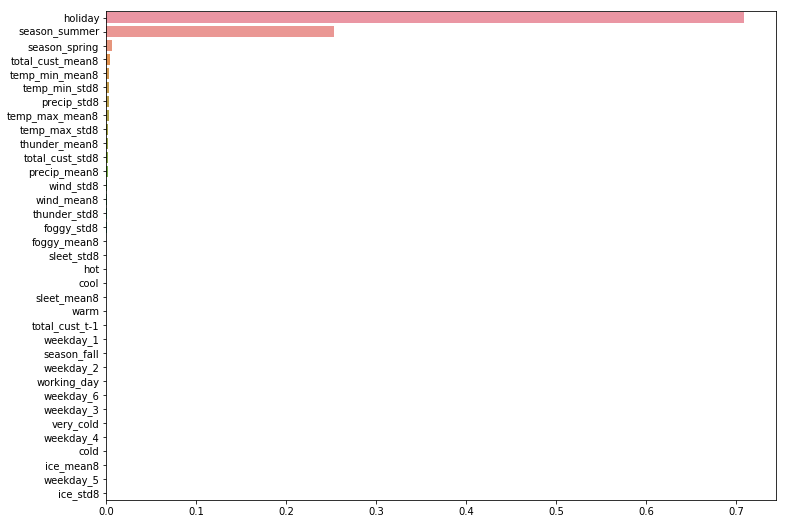

In [191]:
# plot feature importance
plt.figure(figsize=[12,9])
importances = list(pipeline_ada_tuned.steps[1][1].feature_importances_)

imp_dict = {key: val for key, val in zip(list(X.columns), importances)}
sorted_feats = sorted(imp_dict.items(), key=lambda x:x[1], reverse=True)
x_val = [x[0] for x in sorted_feats]
y_val = [x[1] for x in sorted_feats]

#importances.sort(reverse=True)
sb.barplot(y_val, x_val)
#importances

##### running AdaBoost with differenced y

In [192]:
# get the final scores for the differenced data
split = 10
all_scores_test = []
all_scores_train = []

for i in range(split):
    scores_test = split_predict_test(X_train_over, y_train_over, X_test_over, y_test_over, i)
    all_scores_test.append(scores_test)
    scores_train = split_predict_train(X_train_over, y_train_over, X_test_over, y_test_over, i)
    all_scores_train.append(scores_train)
    
rmse_test = []
rmsle_test = []
mae_test = []
rmse_train = []
rmsle_train = []
mae_train = []

for vals in all_scores_test:
    rmse_test.append(vals[0])
    rmsle_test.append(vals[1])
    mae_test.append(vals[2])
    
for vals in all_scores_train:
    rmse_train.append(vals[0])
    rmsle_train.append(vals[1])
    mae_train.append(vals[2])
    
print('Overall Test RMSE:', sum(rmse_test)/split)
print('Overall Test RMSLE:', sum(rmsle_test)/split)
print('Overall Test MAE:', sum(mae_test)/split)

print('Overall Train RMSE:', sum(rmse_train)/split)
print('Overall Train RMSLE:', sum(rmsle_train)/split)
print('Overall Train MAE:', sum(mae_train)/split)
    

Overall Test RMSE: 2028.3718290292738
Overall Test RMSLE: 0.3695759152930953
Overall Test MAE: 1476.5606335547525
Overall Train RMSE: 1321.0266158267432
Overall Train RMSLE: 0.3035541452694844
Overall Train MAE: 915.4651919028851


##### checking how certain features influence the overall performance

In [194]:
# check how the model performance without certain features that are very unimportant
# dropping first 32 results is effective --> Average root mean squared error test data: 2076.794399218362
X_feat_imp = X.drop(columns=['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'])


In [195]:
# creating and fitting the ML pipeline
trend_features = ['total_cust_mean'+str(window), 'total_cust_std'+str(window)]#, 'total_cust_t-1']

preprocessor = ColumnTransformer([
    ('trend_diff', FunctionTransformer(np.log1p, validate=False), trend_features),
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('debug', Debug()) # I have commented this out because it will hinder the execution of this pipeline
    ('model', model_ada_tuned)
])

pipeline_ada_tuned = pipeline.fit(X_feat_imp, y)


In [196]:
# creating a timeseries split of the datasets
time_split = TimeSeriesSplit(n_splits=10)

# doing cross validation on the chunks of data and calculating scores
scores_ada_tuned = cross_validate(pipeline_ada_tuned, X_feat_imp, y, cv=time_split,
                         scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                                  'neg_mean_squared_log_error'],
                         return_train_score=True, n_jobs=-1)


In [197]:
# root mean squared error
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada_tuned['train_neg_mean_squared_error']])/len(scores_ada_tuned['train_neg_mean_squared_error']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada_tuned['test_neg_mean_squared_error']])/len(scores_ada_tuned['test_neg_mean_squared_error']))

# root mean squared log error
print('Average root mean squared error train data:', 
      sum([(-1 * x) for x in scores_ada_tuned['train_neg_mean_absolute_error']])/len(scores_ada_tuned['train_neg_mean_absolute_error']))
print('Average root mean squared error test data:', 
      sum([(-1 * x) for x in scores_ada_tuned['test_neg_mean_absolute_error']])/len(scores_ada_tuned['test_neg_mean_absolute_error']))

# root mean squared log error
print('Average root mean squared error train data:', 
      sum([(-1 * x) for x in scores_ada_tuned['train_neg_mean_squared_log_error']])/len(scores_ada_tuned['train_neg_mean_squared_log_error']))
print('Average root mean squared error test data:', 
      sum([(-1 * x) for x in scores_ada_tuned['test_neg_mean_squared_log_error']])/len(scores_ada_tuned['test_neg_mean_squared_log_error']))



Average root mean squared error train data: 1088.9490598141822
Average root mean squared error test data: 2051.8466751090386
Average root mean squared error train data: 771.7425633096849
Average root mean squared error test data: 1608.8164505746881
Average root mean squared error train data: 0.09350515336093604
Average root mean squared error test data: 0.14251414201899432


#### 4.3. XGBoost

##### running XGBoost with undifferenced y

In [198]:
# initializing XGBoost model with default hyperparameters
model_xgb = xgb.XGBRegressor(random_state=42)

# creating and fitting the ML pipeline
trend_features = ['total_cust_mean'+str(window), 'total_cust_std'+str(window), 'total_cust_t-1']

preprocessor = ColumnTransformer([
    ('trend_diff', FunctionTransformer(np.log1p, validate=False), trend_features),
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler()),
    #('debug', Debug()) # I have commented this out because it will hinder the execution of this pipeline
    ('model', model_xgb)
])

pipeline_xgb = pipeline.fit(X, y)


C:\Users\julia\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\julia\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[12:51:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [199]:
# creating a timeseries split of the datasets
time_split = TimeSeriesSplit(n_splits=10)

# doing cross validation on the chunks of data and calculating scores
scores_xgb = cross_validate(pipeline_xgb, X, y, cv=time_split,
                         scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                                  'neg_mean_squared_log_error'],
                         return_train_score=True, n_jobs=-1)


In [200]:
# root mean squared error
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_xgb['train_neg_mean_squared_error']])/len(scores_xgb['train_neg_mean_squared_error']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_xgb['test_neg_mean_squared_error']])/len(scores_xgb['test_neg_mean_squared_error']))

# mean absolute error
print('Average mean absolute error train data:', 
      sum([(-1 * x) for x in scores_xgb['train_neg_mean_absolute_error']])/len(scores_xgb['train_neg_mean_absolute_error']))
print('Average mean absolute error test data:', 
      sum([(-1 * x) for x in scores_xgb['test_neg_mean_absolute_error']])/len(scores_xgb['test_neg_mean_absolute_error']))

# root mean squared log error
print('Average root mean squared log error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_xgb['train_neg_mean_squared_log_error']])/len(scores_xgb['train_neg_mean_squared_log_error']))
print('Average root mean squared log error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_xgb['test_neg_mean_squared_log_error']])/len(scores_xgb['test_neg_mean_squared_log_error']))


Average root mean squared error train data: 951.0249490360686
Average root mean squared error test data: 2104.5766428136335
Average mean absolute error train data: 677.314756604036
Average mean absolute error test data: 1653.9828688650418
Average root mean squared log error train data: 0.27807398881506395
Average root mean squared log error test data: 0.3724893122198019


In [201]:
# alpha
alpha = uniform(0.2, 0.5)
# learning rate
learning_rate = uniform(0, 1)
# colsample_bytree
colsample_bytree = uniform(0, 1)
# max depth
n_estimators = randint(300, 1000)
# min child weight
min_child_weight = randint(5, 10)
# max_depth
max_depth = randint(1, 5)
# subsample
subsample = uniform(0, 1)

# Create the random grid
random_grid_xgb = {'model__n_estimators': n_estimators,
                   'model__learning_rate': learning_rate,
                   'model__reg_alpha': alpha,
                   'model__colsample_bytree': colsample_bytree,
                   'model__min_child_weight': min_child_weight,
                   'model__max_depth': max_depth,
                   'model__subsample': subsample}


In [202]:
# check the start time
start_time = datetime.now()
print(start_time)

# instantiate and fit the randomizedsearch class to the random parameters
rs_xgb = RandomizedSearchCV(pipeline_xgb, 
                        param_distributions=random_grid_xgb, 
                        scoring='neg_mean_squared_error', 
                        n_jobs=-1,
                        cv=time_split,
                        n_iter = 10,
                        verbose=10,
                        random_state=10)
rs_xgb = rs_xgb.fit(X, y)

# print the total running time
end_time = datetime.now()
print('Total running time:', end_time-start_time)
    

2020-01-13 12:51:24.215053
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished
C:\Users\julia\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\julia\Anaconda3\lib\site-pac

[12:52:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total running time: 0:01:33.521332


In [203]:
# Saving the best RandomForest model
pickle.dump(rs_xgb.best_estimator_, open('xgboost.sav', 'wb'))

# change the keys of the best_params dictionary to allow it to be used for the final model
fix_best_params_xgb = {key[7:]: val for key, val in rs_xgb.best_params_.items()}

print(fix_best_params_xgb)

# fit the randomforestregressor with the best_params as hyperparameters
model_xgb_rs = xgb.XGBRegressor(**fix_best_params_xgb)


{'colsample_bytree': 0.8568503024577332, 'learning_rate': 0.3516526394320879, 'max_depth': 1, 'min_child_weight': 7, 'n_estimators': 664, 'reg_alpha': 0.6361962299195545, 'subsample': 0.9830208668523404}


In [204]:
# creating and fitting the ML pipeline
trend_features = ['total_cust_mean'+str(window), 'total_cust_std'+str(window), 'total_cust_t-1']

preprocessor = ColumnTransformer([
    ('trend_diff', FunctionTransformer(np.log1p, validate=False), trend_features),
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler()),
    #('debug', Debug()) # I have commented this out because it will hinder the execution of this pipeline
    ('model', model_xgb_rs)
])

pipeline_xgb_rs = pipeline.fit(X, y)


[12:52:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\julia\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\julia\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [205]:
# creating a timeseries split of the datasets
time_split = TimeSeriesSplit(n_splits=10)

# doing cross validation on the chunks of data and calculating scores
scores_xgb_rs = cross_validate(pipeline_xgb_rs, X, y, cv=time_split,
                         scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                                  'neg_mean_squared_log_error'],
                         return_train_score=True, n_jobs=-1)


In [206]:
# root mean squared error
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_xgb_rs['train_neg_mean_squared_error']])/len(scores_xgb_rs['train_neg_mean_squared_error']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_xgb_rs['test_neg_mean_squared_error']])/len(scores_xgb_rs['test_neg_mean_squared_error']))

# root mean squared log error
print('Average root mean squared error train data:', 
      sum([(-1 * x) for x in scores_xgb_rs['train_neg_mean_absolute_error']])/len(scores_xgb_rs['train_neg_mean_absolute_error']))
print('Average root mean squared error test data:', 
      sum([(-1 * x) for x in scores_xgb_rs['test_neg_mean_absolute_error']])/len(scores_xgb_rs['test_neg_mean_absolute_error']))

# root mean squared log error
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_xgb_rs['train_neg_mean_squared_log_error']])/len(scores_xgb_rs['train_neg_mean_squared_log_error']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_xgb_rs['test_neg_mean_squared_log_error']])/len(scores_xgb_rs['test_neg_mean_squared_log_error']))



Average root mean squared error train data: 1019.6082875959104
Average root mean squared error test data: 1951.375855891532
Average root mean squared error train data: 726.892841300831
Average root mean squared error test data: 1508.7830899325286
Average root mean squared error train data: 0.28996431446794074
Average root mean squared error test data: 0.3629069332963537


In [207]:
#{'colsample_bytree': 0.8568503024577332, 'learning_rate': 0.3516526394320879, 'max_depth': 1, 'min_child_weight': 7, 
 #'n_estimators': 664, 'reg_alpha': 0.6361962299195545, 'subsample': 0.9830208668523404}
# specify some values for hyperparameters around the values chosen by randomizedsearch
grid_param_xgb = {'model__n_estimators': [664, 650],
                   'model__learning_rate': [0.35, 0.04],
                   'model__alpha': [0.636, 0.6],
                   'model__colsample_bytree': [0.85, 0.9],
                   'model__min_child_weight': [7, 8],
                   'model__max_depth': [1, 2],
                   'model__subsample': [0.98, 0.90]}

# use gridsearch to search around the randomizedsearch best parameters and further improve the model
gs_xgb = GridSearchCV(pipeline_xgb, 
                  param_grid=grid_param_xgb, 
                  scoring='neg_mean_squared_error', 
                  verbose = 10,
                  n_jobs=-1, 
                  cv=time_split)

gs_xgb = gs_xgb.fit(X, y)


Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

[13:14:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [208]:
# Saving the best XGB model
pickle.dump(gs_xgb.best_estimator_, open('xgboost.sav', 'wb'))

# change the keys of the best_params dictionary to allow it to be used for the final model
fix_best_params_xgb = {key[7:]: val for key, val in gs_xgb.best_params_.items()}

print(fix_best_params_xgb)

# fit the randomforestregressor with the best_params as hyperparameters
model_xgb_tuned = xgb.XGBRegressor(**fix_best_params_xgb)


{'alpha': 0.636, 'colsample_bytree': 0.9, 'learning_rate': 0.04, 'max_depth': 1, 'min_child_weight': 8, 'n_estimators': 664, 'subsample': 0.98}


In [209]:
# creating and fitting the ML pipeline
trend_features = ['total_cust_mean'+str(window), 'total_cust_std'+str(window), 'total_cust_t-1']

preprocessor = ColumnTransformer([
    ('trend_diff', FunctionTransformer(np.log1p, validate=False), trend_features),
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler()),
    #('debug', Debug()) # I have commented this out because it will hinder the execution of this pipeline
    ('model', model_xgb_tuned)
])

pipeline_xgb_tuned = pipeline.fit(X, y)


[13:14:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\julia\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\julia\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [218]:
# creating a timeseries split of the datasets
time_split = TimeSeriesSplit(n_splits=10)

# check the start time
start_time = datetime.now()

# doing cross validation on the chunks of data and calculating scores
scores_xgb_tuned = cross_validate(pipeline_xgb_tuned, X, y, cv=time_split,
                         scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                                  'neg_mean_squared_log_error'],
                         return_train_score=True, n_jobs=-1)

# print the total running time
end_time = datetime.now()
print('Total cross validation time for XGBBoost:', (end_time-start_time).total_seconds())


Total cross validation time for XGBBoost: 5.238942


In [211]:
# root mean squared error
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_xgb_tuned['train_neg_mean_squared_error']])/len(scores_xgb_tuned['train_neg_mean_squared_error']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_xgb_tuned['test_neg_mean_squared_error']])/len(scores_xgb_tuned['test_neg_mean_squared_error']))

# root mean squared log error
print('Average root mean squared error train data:', 
      sum([(-1 * x) for x in scores_xgb_tuned['train_neg_mean_absolute_error']])/len(scores_xgb_tuned['train_neg_mean_absolute_error']))
print('Average root mean squared error test data:', 
      sum([(-1 * x) for x in scores_xgb_tuned['test_neg_mean_absolute_error']])/len(scores_xgb_tuned['test_neg_mean_absolute_error']))

# root mean squared log error
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_xgb_tuned['train_neg_mean_squared_log_error']])/len(scores_xgb_tuned['train_neg_mean_squared_log_error']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_xgb_tuned['test_neg_mean_squared_log_error']])/len(scores_xgb_tuned['test_neg_mean_squared_log_error']))


Average root mean squared error train data: 1150.6434257135422
Average root mean squared error test data: 1919.9286080010781
Average root mean squared error train data: 807.9341907416774
Average root mean squared error test data: 1484.2496555212772
Average root mean squared error train data: 0.31772367269057444
Average root mean squared error test data: 0.35649910640792204


In [212]:
# map the feature importances to the feature names
xgb_feats = X.columns
xgb_feats_dict = defaultdict()
count = 0

for item in xgb_feats:
    xgb_feats_dict['f'+str(count)] = item
    count += 1
    

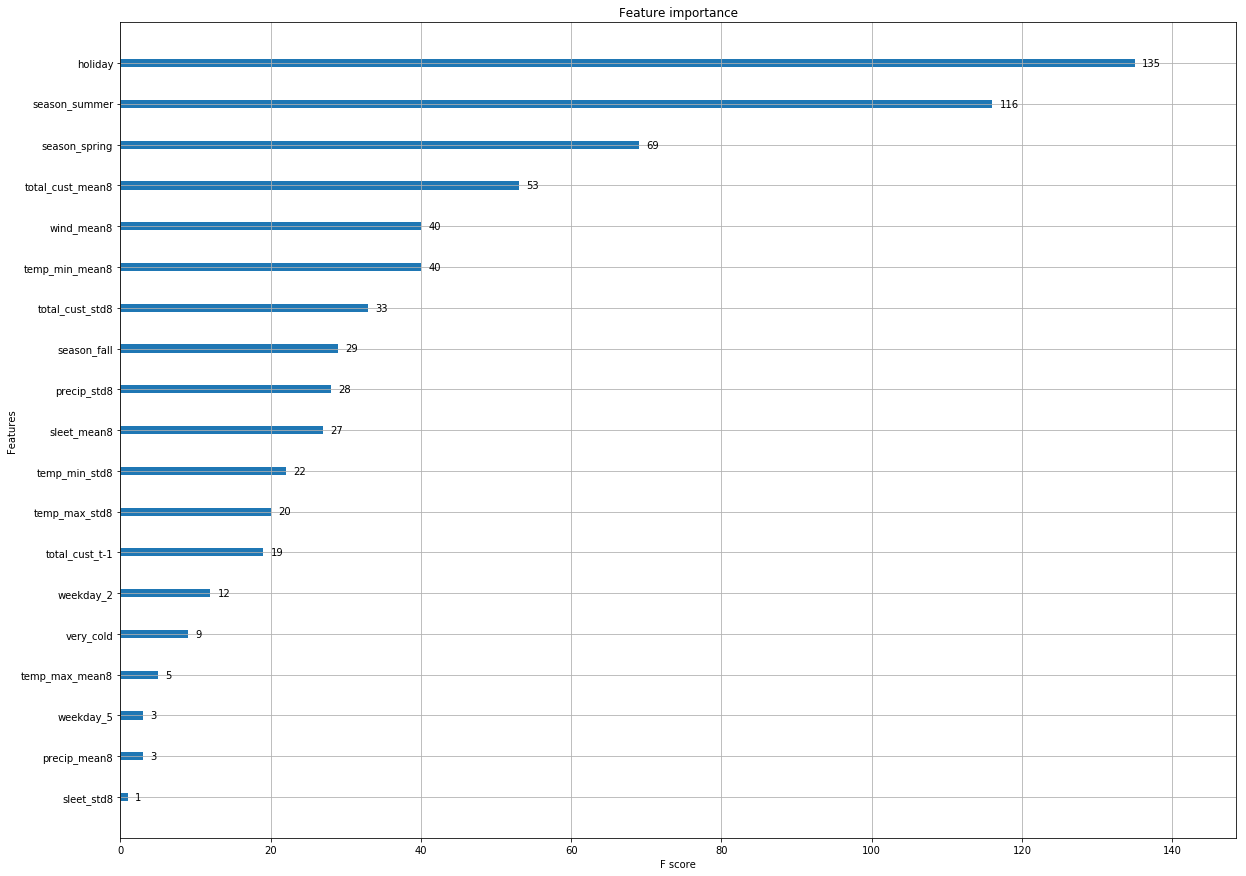

In [213]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(20, 15))
xgb.plot_importance(model_xgb_tuned, importance_type='weight', ax=ax)

# rename the y axis labels to the actual feature names
locs, labels = plt.yticks()

new_names = []
for item in labels:
    for key, name in xgb_feats_dict.items():
        if key == item.get_text():
            new_names.append(name)

ax.set_yticklabels(new_names);
            
plt.show()


##### running XGBoost with differenced y

In [214]:
# get the final scores for the differenced data
split = 10
all_scores_test = []
all_scores_train = []

for i in range(split):
    scores_test = split_predict_test(X_train_over, y_train_over, X_test_over, y_test_over, i)
    all_scores_test.append(scores_test)
    scores_train = split_predict_train(X_train_over, y_train_over, X_test_over, y_test_over, i)
    all_scores_train.append(scores_train)
    
rmse_test = []
rmsle_test = []
mae_test = []
rmse_train = []
rmsle_train = []
mae_train = []

for vals in all_scores_test:
    rmse_test.append(vals[0])
    rmsle_test.append(vals[1])
    mae_test.append(vals[2])
    
for vals in all_scores_train:
    rmse_train.append(vals[0])
    rmsle_train.append(vals[1])
    mae_train.append(vals[2])
    
print('Overall Test RMSE:', sum(rmse_test)/split)
print('Overall Test RMSLE:', sum(rmsle_test)/split)
print('Overall Test MAE:', sum(mae_test)/split)

print('Overall Train RMSE:', sum(rmse_train)/split)
print('Overall Train RMSLE:', sum(rmsle_train)/split)
print('Overall Train MAE:', sum(mae_train)/split)
    

[13:14:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:50] WARNI

##### checking how certain features influence the overall performance

In [222]:
# check how the model performance without certain features that are very unimportant
X_feat_imp = X.drop(columns=['weekday_1', 'weekday_3', 'weekday_4', 'weekday_6',
                             'hot', 'cold', 'cool', 'warm'])


In [223]:
# creating and fitting the ML pipeline
trend_features = ['total_cust_mean'+str(window), 'total_cust_std'+str(window), 'total_cust_t-1']

preprocessor = ColumnTransformer([
    ('trend_diff', FunctionTransformer(np.log1p, validate=False), trend_features),
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler()),
    #('debug', Debug()) # I have commented this out because it will hinder the execution of this pipeline
    ('model', model_xgb_tuned)
])

pipeline_xgb_tuned = pipeline.fit(X_feat_imp, y)


C:\Users\julia\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\julia\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:32:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [224]:
# creating a timeseries split of the datasets
time_split = TimeSeriesSplit(n_splits=10)

# doing cross validation on the chunks of data and calculating scores
scores_xgb_tuned = cross_validate(pipeline_xgb_tuned, X_feat_imp, y, cv=time_split,
                         scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                                  'neg_mean_squared_log_error'],
                         return_train_score=True, n_jobs=-1)


In [225]:
# root mean squared error
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_xgb_tuned['train_neg_mean_squared_error']])/len(scores_xgb_tuned['train_neg_mean_squared_error']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_xgb_tuned['test_neg_mean_squared_error']])/len(scores_xgb_tuned['test_neg_mean_squared_error']))

# root mean squared log error
print('Average root mean squared error train data:', 
      sum([(-1 * x) for x in scores_xgb_tuned['train_neg_mean_absolute_error']])/len(scores_xgb_tuned['train_neg_mean_absolute_error']))
print('Average root mean squared error test data:', 
      sum([(-1 * x) for x in scores_xgb_tuned['test_neg_mean_absolute_error']])/len(scores_xgb_tuned['test_neg_mean_absolute_error']))

# root mean squared log error
print('Average root mean squared error train data:', 
      sum([np.sqrt(-1 * x) for x in scores_xgb_tuned['train_neg_mean_squared_log_error']])/len(scores_xgb_tuned['train_neg_mean_squared_log_error']))
print('Average root mean squared error test data:', 
      sum([np.sqrt(-1 * x) for x in scores_xgb_tuned['test_neg_mean_squared_log_error']])/len(scores_xgb_tuned['test_neg_mean_squared_log_error']))


Average root mean squared error train data: 1152.7850906956025
Average root mean squared error test data: 1925.9614236849898
Average root mean squared error train data: 811.4159676098359
Average root mean squared error test data: 1491.663044461337
Average root mean squared error train data: 0.3180193228664518
Average root mean squared error test data: 0.3573161669951669
